In [1]:
import numpy as np
import os
import sys
import scipy
import cv2

#解析使用
import xml
from xml.etree import ElementTree as ET

from glob import glob

import keras.backend as K
from keras.applications import VGG19
from keras.models import Model
from keras.utils import to_categorical

import imageio
from skimage import transform

from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.svm import SVC #类别分类使用
from sklearn.linear_model import Ridge #bounding-box回归
from sklearn.externals import joblib

C:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import tensorflow as tf
import pandas as pd

import selectivesearch as ss #候选框产生使用

from ImageNet_classes import class_names #验证alexnet使用

In [3]:
#BATCH_SIZE = 1 #一次一张图像 切勿修改

PROPOSAL_SIZE_POSITIVE = 32 #finetune 正样本
PROPOSAL_SIZE_NEGATIVE = 96 #finetune 负样本
PROPOSAL_SIZE = PROPOSAL_SIZE_POSITIVE+PROPOSAL_SIZE_NEGATIVE #128

#应该是224 224 3
#使用预训练的alexnet 58% 或者vgg16 66%
HEIGHT = 224
WIDTH = 224
CHANNEL = 3

IMG_SHAPE = (HEIGHT , WIDTH , CHANNEL)

TRAIN_DATA_PATH = '../../tensorflow2/dataset/VOCtrainval_11-May-2012/JPEGImages/'
#TEST_DATA_PATH = '../../tensorflow2/dataset/VOC2012test/JPEGImages/'

TRAIN_XML_PATH = '../../tensorflow2/dataset/VOCtrainval_11-May-2012/Annotations/'
#TEST_XML_PATH = '../../tensorflow2/dataset/VOC2012test/Annotations/'

OBJECT_PATH = '../../tensorflow2/dataset/VOCtrainval_11-May-2012/ImageSets/Main/' #SVM需要使用的训练数据（正负样本） 训练20个svm

#pascal VOC数据集目标数量
#目标的数目 还有一个背景
CLASSES_NUM = 20+1

STR = [
    'background', #label=0
    'person',
    'bird','cat','cow','dog','horse','sheep',
    'aeroplane','bicycle','boat','bus','car','motorbike','train',
    'bottle','chair','diningtable','pottedplant','sofa','tvmonitor'
]

LABEL2STR = {idx:value for idx , value in enumerate(STR)}
STR2LABEL = {value:key for key,value in LABEL2STR.items()}

STR2LABEL['none'] = 'none' #先不使用part部分 只进行naive目标检测

#目标检测相关
IoU_THRESHOLD = 0.5

#SVM相关
SVM_IoU_THRESHOLD = 0.3

#NMS相关
NMS_IoU_THRESHOLD = 0.3 #or ~0.5

#bbox回归
BBOX_REGRESS_IoU_THRESHOLD = 0.6

#spp相关
#spp格子
SPP_BINS = [8 , 6 , 4]

HIDDEN_DIMS = np.sum([elem*elem for elem in SPP_BINS])

In [4]:
def spatial_pyramid_pool(conv5 , pyramid_bins): #[8 6 4]
    '''
    spp已经拉成向量
    一共batch_size个向量
    '''
    batch_size = conv5.get_shape().as_list()[0] #batch_size
    conv5_height = conv5.get_shape().as_list()[1] #feature map height
    conv5_width = conv5.get_shape().as_list()[2] #feature map width
    
    #channel = conv5.get_shape().as_list()[3]

    for i in range(len(pyramid_bins)):
        pooling_height = np.ceil(conv5_height / pyramid_bins[i])
        stride_height = np.ceil(conv5_height / pyramid_bins[i]) #floor
        
        pooling_width = np.ceil(conv5_width / pyramid_bins[i])
        stride_width = np.ceil(conv5_width / pyramid_bins[i]) #floor
        
        padding_height = int(pyramid_bins[i] * pooling_height - conv5_height)
        padding_width = int(pyramid_bins[i] * pooling_width - conv5_width)
        
        conv5_padding = tf.pad(conv5 , tf.constant([[0,0] , [0,padding_height] , [0,padding_width] ,[0,0]]))
        
        #max_pooling = tf.layers.max_pooling2d(conv5_padding , [pooling_height , pooling_width] , [stride_height , stride_width] , padding='same')
        max_pooling = tf.nn.max_pool(conv5_padding , ksize=[1,pooling_height,pooling_width,1] , strides=[1,stride_height,stride_width,1] , padding='SAME')
        
        if i==0:
            spp = tf.reshape(max_pooling , shape=(batch_size , -1))
        else:
            spp = tf.concat(values=[spp , tf.reshape(max_pooling , shape=(batch_size , -1)) ] , axis=-1)
            
    return spp

In [5]:
#refer:https://blog.csdn.net/two_vv/article/details/76769860
#alexnet原始模型以及预训练参数导入

class AlexNet_model(object):
    #使用了sppnet的alexnet
    def __init__(self , x , keep_prob , num_classes):
        self.X = x
        self.NUM_CLASSES = num_classes
        self.KEEP_PROB = keep_prob
                
        self.model()
        
    def group_conv(self , x , kernel , strides):
        #2 GPUs
        #原始alexnet配置
        group_x = tf.split(x , num_or_size_splits=2 , axis=3)
        group_kernel = tf.split(kernel , num_or_size_splits=2 , axis=3)

        group_conv0 = tf.nn.conv2d(group_x[0] , group_kernel[0] , strides=strides , padding='SAME')
        group_conv1 = tf.nn.conv2d(group_x[1] , group_kernel[1] , strides=strides , padding='SAME')

        group_conv = tf.concat((group_conv0 , group_conv1) , axis=3)

        return group_conv
    
    #构建alexnet模型
    def model(self):
        #=======
        #加载预训练权重
        #获取预训练参数
        net_data = np.load('bvlc_alexnet.npy' , encoding='bytes').item() #不加encoding='bytes' 死机
        conv1w = tf.Variable(net_data["conv1"][0] , trainable=False)
        conv1b = tf.Variable(net_data["conv1"][1] , trainable=False)

        conv2w = tf.Variable(net_data["conv2"][0] , trainable=False)
        conv2b = tf.Variable(net_data["conv2"][1] , trainable=False)

        conv3w = tf.Variable(net_data["conv3"][0] , trainable=False)
        conv3b = tf.Variable(net_data["conv3"][1] , trainable=False)

        conv4w = tf.Variable(net_data["conv4"][0] , trainable=False)
        conv4b = tf.Variable(net_data["conv4"][1] , trainable=False)

        conv5w = tf.Variable(net_data["conv5"][0] , trainable=False)
        conv5b = tf.Variable(net_data["conv5"][1] , trainable=False)

        #不敢用4096 爆显存
        fc6w = tf.Variable(tf.truncated_normal(shape=(HIDDEN_DIMS * 256 , 1024) , stddev=1e-2))
        fc6b = tf.Variable(tf.constant(0.1 , shape=[1024]))
        #fc6b = tf.Variable(net_data['fc6'][1])

        fc7w = tf.Variable(tf.truncated_normal(shape=(1024 , self.NUM_CLASSES) , stddev=1e-2))
        fc7b = tf.Variable(tf.constant(0.1 , shape=[self.NUM_CLASSES]))

        #下面不敢使用 爆显存
        #fc7w = tf.Variable(net_data['fc7'][0])
        #fc7b = tf.Variable(net_data['fc7'][1])

        #fc8w = tf.Variable(tf.truncated_normal(shape=(4096 , num_classes) , stddev=1e-2))
        #fc8b = tf.Variable(tf.constant(0.1 , shape=[num_classes]))
        #=======
        
        conv1 = tf.nn.conv2d(self.X , conv1w , strides=(1,4,4,1) , padding='SAME')
        conv1 = tf.nn.bias_add(conv1 , conv1b)
        conv1 = tf.nn.relu(conv1)
        lrn1 = tf.nn.local_response_normalization(conv1 , depth_radius=5 , alpha=0.0001 , beta=0.75 , bias=1.0)
        maxpool1 = tf.nn.max_pool(lrn1 , ksize=(1,3,3,1) , strides=(1,2,2,1) , padding='VALID')

        conv2 = self.group_conv(maxpool1 , conv2w , strides=(1,1,1,1))
        conv2 = tf.nn.bias_add(conv2 , conv2b)
        conv2 = tf.nn.relu(conv2)
        lrn2 = tf.nn.local_response_normalization(conv2 , depth_radius=5 , alpha=0.0001 , beta=0.75 , bias=1.0)
        maxpool2 = tf.nn.max_pool(lrn2 , ksize=(1,3,3,1) , strides=(1,2,2,1) , padding='VALID')

        conv3 = tf.nn.conv2d(maxpool2 , conv3w , strides=(1,1,1,1) , padding='SAME')
        conv3 = tf.nn.bias_add(conv3 , conv3b)
        conv3 = tf.nn.relu(conv3)

        conv4 = self.group_conv(conv3 , conv4w , strides=(1,1,1,1))
        conv4 = tf.nn.bias_add(conv4 , conv4b)
        conv4 = tf.nn.relu(conv4)

        conv5 = self.group_conv(conv4 , conv5w , strides=(1,1,1,1))
        conv5 = tf.nn.bias_add(conv5 , conv5b)
        conv5 = tf.nn.relu(conv5)

        maxpool5 = spatial_pyramid_pool(conv5 , SPP_BINS) #增加spp结构

        '''
        maxpool5 已经拉成向量 shape:batch length
        '''
        # print(maxpool5.get_shape().as_list()) #debug

        fc6 = tf.nn.relu_layer(maxpool5 , fc6w , fc6b)
        fc6 = tf.nn.dropout(fc6 , self.KEEP_PROB)
        self.fc6 = fc6 #1024维

        fc7 = tf.nn.xw_plus_b(fc6 , fc7w , fc7b)

        self.fc7 = fc7 #21维度 20+1

        #下面的不敢使用 爆显存
        #fc7 = tf.nn.relu_layer(fc6 , fc7w , fc7b)
        #fc7 = tf.nn.dropout(fc7 , keep_prob)
        #
        #fc8 = tf.nn.xw_plus_b(fc7 , fc8w , fc8b) #需要softmax激活

        #self.logits = fc8


In [6]:
xml_file_names_train = glob(TRAIN_XML_PATH + '*') #所有的xml文件 完整路径

#从xml文件中读出图片相关的信息

def xml_parse(xml_file):
    '''
    return filename , shape , name_boxes , crop_boxes
    xml文件中的shape格式为 (width height 3)
    '''
    xml_file = xml.dom.minidom.parse(xml_file)
    xml_file_docu_ele = xml_file.documentElement

    filename_list = xml_file_docu_ele.getElementsByTagName('filename')
    
    #filename_list可能有多个filename的 所以要索引0(此数据集中filename只有一个)
    filename = filename_list[0].childNodes[0].data #filename_list.firstChild.data

    #图像的尺寸信息
    size_list = xml_file_docu_ele.getElementsByTagName('size')

    for size in size_list:
        width_list = size.getElementsByTagName('width')
        width = int(width_list[0].childNodes[0].data)

        height_list = size.getElementsByTagName('height')
        height = int(height_list[0].childNodes[0].data)

        channel_list = size.getElementsByTagName('depth')
        channel = int(channel_list[0].childNodes[0].data)

    shape = (width , height , channel)

    #一个文件中有多个object
    object_list = xml_file_docu_ele.getElementsByTagName('object')

    #多个object与多个object对应的详细信息
    name_boxes = [] #一个元素就是一个object
    crop_boxes = []

    for objects in object_list:
        #一次循环处理一个object信息
        #一个xml文件（即一个图像中）有多个object

        #name
        name_list = objects.getElementsByTagName('name')

        name_box = name_list[0].childNodes[0].data

        #bounding box points
        bndbox = objects.getElementsByTagName('bndbox')

        x1_list = bndbox[0].getElementsByTagName('xmin')
        x1 = int( round( float(x1_list[0].childNodes[0].data) ) )

        y1_list = bndbox[0].getElementsByTagName('ymin')
        y1 = int(round(float( y1_list[0].childNodes[0].data )))

        x2_list = bndbox[0].getElementsByTagName('xmax')
        x2 = int(round(float( x2_list[0].childNodes[0].data )))

        y2_list = bndbox[0].getElementsByTagName('ymax')
        y2 = int(round(float( y2_list[0].childNodes[0].data )))

        crop_box = [x1,x2,y1,y2]

        name_boxes.append(name_box)
        crop_boxes.append(crop_box)

    #shape:[width height channel]
    #crop_box:[x1 x2 y1 y2]
    return filename , shape , name_boxes , crop_boxes

#xml_parse(xml_file_names_train[10])

In [7]:
xml_parse(xml_file_names_train[11])

('2007_000170.jpg',
 (500, 375, 3),
 ['bottle', 'bottle', 'bottle', 'bottle', 'person', 'person'],
 [[87, 109, 100, 165],
  [41, 73, 114, 181],
  [324, 352, 148, 206],
  [426, 443, 157, 195],
  [3, 43, 91, 206],
  [4, 461, 28, 372]])

In [7]:
class Image(object):
    '''
    图片的真实信息
    '''
    def __init__(self):
        self.img_file_names_train = glob(TRAIN_DATA_PATH+'*') #训练全路径信息
                
    def load(self , img_path_name = None):
        '''
        如果传入 传入完整路径信息
        return img_arr , proposals , labels , crop_boxes , img_path_name[-15:-4]
        img_arr的shape为 (height width 3) 与xml文件中区分
        proposals:ground truth 具体数据
        '''
        if not img_path_name:
            #没有指定文件名
            img_path_name = np.random.choice(self.img_file_names_train) #随机选择一张图片
            #img_path_idx = np.random.randint(0 , high = len(self.img_file_names_train)) #随机索引
        
        #else
            #svm和bndbox回归时使用 需要指定图片的路径信息
            #完整路径信息
        
        #img_arr = imageio.imread(img_name) #使用此函数打开 导致迁移失败 RGB height*width*channel
        img_arr = cv2.imread(img_path_name) #BGR height*width*chanel
        #img_arr = np.array(img_arr)
        
        xml_file_name = TRAIN_XML_PATH + img_path_name[-15:-4] +  '.xml'
        
        _ , _ , name_boxes , crop_boxes = xml_parse(xml_file_name)
        
        ground_truth_data = [] #存储bndbox的图像 数据信息
        labels = [] #存储与bndbox对应的 label信息

        for i in range(len(crop_boxes)): #多个object
            x1 = crop_boxes[i][0]
            x2 = crop_boxes[i][1]
            y1 = crop_boxes[i][2]
            y2 = crop_boxes[i][3]
            
            ground_truth_data.append(img_arr[y1:y2 , x1:x2 , :])
            
            labels.append(STR2LABEL.get(name_boxes[i] , 'none'))
        
        #图片数据 ground truth具体数据 bndbox对应label bndbox坐标信息 图片文件名
        
        return img_arr , ground_truth_data , labels , crop_boxes , img_path_name[-15:-4]
    

In [8]:
#候选区域的产生
class Clip(object):
    '''
    selectivesearch 产生与图片相关的信息 候选信息
    '''
    def __init__(self):
        self.size_threshold = 220 #ss算法产生过小的bbox略去

    #单张图像裁剪函数 产生~2k的候选区域
    #返回值：候选区域的位置坐标
    def clip(self , img_arr):
        '''
        由ss算法对img_arr产生~2K proposals
        '''
        #传入图片张量
        #关键函数
        #return rects
        _ , regions = ss.selective_search(img_arr , 500 , 0.9 , 50) #可以调整ss算法的参数 _为ss算法产生的labels
        
        rects = []
        
        no_repeat = set() #保证候选框不重复出现
        
        for r in regions:
            if r['rect'] in no_repeat:
                # 已经存在了
                continue
            
            if r['size'] < self.size_threshold:
                # 小于指定size
                continue
            
            x , y , w , h = r['rect']
            
            if w == 0 or h == 0:
                continue
            
            #img_arr的shape为 height width channel
            d0 , d1 , d2 = img_arr[y:y+h , x:x+w , :].shape
            
            if d0 == 0 or d1 == 0 or d2 == 0:
                continue
                
            no_repeat.add(r['rect'])
            
            rects.append([x , x+w , y , y+h]) #x1 x2 y1 y2形式
        
        return rects
    
    def _preprocess(self , img_arr):
        
        #TODO
        #对ss产生的候选区域进行预处理
        #例如 resize
        
        img_arr = cv2.resize(img_arr , (HEIGHT , WIDTH))
        
        img_arr = img_arr/127.5-1.0
        
        return img_arr
    
    #返回数组表示候选区域的具体数据信息
    def clip_region(self , img_arr , rects = None):
        '''
        return rects_region 具体数据信息
        rects_region的shape为(height width 3)
        '''
        if not rects:
            rects = self.clip(img_arr)
        
        rects_region = []
        
        for x1 , x2 , y1 , y2 in rects:
            rects_region.append( self._preprocess(img_arr[y1:y2 , x1:x2 , :]) ) #正确的切片格式
            
            #预处理函数可以进行数据增强 故换为+
            #rects_region += ( self._preprocess(img_arr[y1:y2 , x1:x2 , :]) )

        return rects_region
    

In [9]:
class Img_generator(object):
    def __init__(self):
        
        self.pr_generator = Clip()
        self.img_loader = Image()

    #计算bbox面积
    def bbox_area(self , bbox):
        w = bbox[1] - bbox[0]
        h = bbox[3] - bbox[2]
        
        return w*h
    
    #计算交并比
    def IoU(self , bbox_a , bbox_b):
        xmin_a = bbox_a[0]
        xmax_a = bbox_a[1]
        ymin_a = bbox_a[2]
        ymax_a = bbox_a[3]
        
        xmin_b = bbox_b[0]
        xmax_b = bbox_b[1]
        ymin_b = bbox_b[2]
        ymax_b = bbox_b[3]
        
        if   xmin_a < xmax_b <= xmax_a and (ymin_a < ymax_b <= ymax_a or ymin_a <= ymin_b < ymax_a):
            flag = True
        elif xmin_a <= xmin_b < xmax_a and (ymin_a < ymax_b <= ymax_a or ymin_a <= ymin_b < ymax_a):
            flag = True
        elif xmin_b < xmax_a <= xmax_b and (ymin_b < ymax_a <= ymax_b or ymin_b <= ymin_a < ymax_b):
            flag = True
        elif xmin_b <= xmin_a < xmax_b and (ymin_b < ymax_a <= ymax_b or ymin_b <= ymin_a < ymax_b):
            flag = True
        else:
            flag = False
        
        if flag:
            x_sorted_list = sorted([xmin_a, xmax_a, xmin_b, xmax_b])
            y_sorted_list = sorted([ymin_a, ymax_a, ymin_b, ymax_b])
            
            x_intersect_w = x_sorted_list[2] - x_sorted_list[1] #0 1 2 3
            y_intersect_h = y_sorted_list[2] - y_sorted_list[1] #0 1 2 3
            
            area_inter = x_intersect_w * y_intersect_h #计算重合面积
            
            union_area = self.bbox_area(bbox_a) + self.bbox_area(bbox_b) - area_inter
            
            return area_inter/union_area
        else:
            return 0.0
    
    def get_train_proposal(self , img_arr , labels , crop_boxes):
        '''
        构建训练数据 构建 前景和背景 训练集
        
        positive_data positive_labels 正样本
        negative_data negative_labels 负样本
        '''
        proposal_position = self.pr_generator.clip(img_arr) #ss算法产生的bbox
        
        proposal_value = self.pr_generator.clip_region(img_arr , proposal_position) #ss算法产生的具体图像数据
        
        #====
        positive_labels = []
        negative_labels = []
        
        positive_data = []
        negative_data = []
   
        #====
        
        for i in range(len(crop_boxes)): #一幅图的人工标定bbox proposal ground truth 每一个ground truth对应一个label
            for j in range(len(proposal_position)): #一幅图的ss产生的bbox
                
                '''
                fast rcnn中对此处有修改
                '''
                if self.IoU(crop_boxes[i] , proposal_position[j]) < IoU_THRESHOLD: #0.5
                    #小于阈值 label为背景
                    negative_labels.append(0)
                    negative_data.append(proposal_value[j])
                    
                else:
                    #大于阈值 label为正常label
                    positive_labels.append(labels[i])
                    positive_data.append(proposal_value[j])
                
        return (positive_data , to_categorical(positive_labels , num_classes=CLASSES_NUM) , #CLASSES_NUM=21
                 negative_data , to_categorical(negative_labels , num_classes=CLASSES_NUM) )
                
    def load(self , img_path_name = None):
        '''
        对cnn进行微调
        img_path_name:指定的图片的绝对路径
        '''
        
        #图片数据 ground truth具体数据 ground truth对应label ground truth坐标信息 图片文件名
        img_arr , _ , labels , crop_boxes , _ = self.img_loader.load(img_path_name)
        
        return self.get_train_proposal(img_arr , labels , crop_boxes)
    
    #============
    #============
    '''推理阶段使用'''
    
    #Alexnet_finetune demo 和 SVM_set中使用
    def one_img_rect_region(self , path): 
        '''
        返回指定的图像由ss算法产生的proposals信息
        '''
        img_arr = cv2.imread(path) #BGR height*width*chanel
        
        proposals = self.pr_generator.clip(img_arr) #proposal*4(x1,x2,y1,y2) selectivesearch算法产生
        proposals_region = self.pr_generator.clip_region(img_arr , proposals) #proposal*224*224*3
        
        return img_arr , proposals , proposals_region
    
    #svm使用
    def one_img_rect_region_label_svm(self , path , label):
        '''
        返回ground truth信息 给svm使用
        一个类别训练一个svm使用 ovr形式
        返回与参数label相同的数据供训练svm
        '''
        #proposals
        img_arr , ground_truth_data , _labels , crop_boxes , _ = self.img_loader.load(path)
        #rects rects_region
        _ , proposals , proposals_region = self.one_img_rect_region(path)
        
        crop_boxes_x = [] #人工标定的框与参数中label对应的
        
        #训练一个类别的svm使用的数据集
        proposals_region_x = [] #候选区域数据
        labels = [] #标记
        
        #寻找与指定label相同的ground truth
        for i in range(len(_labels)):
            if _labels[i] == label:
                crop_boxes_x.append(crop_boxes[i])
        
        #svm训练负样本
        #与人工标定框iou小于0.3的为负样本
        for i in range(len(crop_boxes_x)): #一幅图的与label相对应的人工标定bbox proposal
            for j in range(len(proposals)): #一幅图的ss产生的bbox
                
                if self.IoU(crop_boxes_x[i] , proposals[j]) < SVM_IoU_THRESHOLD: #0.3
                    labels.append(0)
                
                    proposals_region_x.append(proposals_region[j])
        
        #svm训练正样本
        #与label对应的人工标定框的图像数据
        crop_boxes_x_region = self.pr_generator.clip_region(img_arr , crop_boxes_x) #proposal*227*227*3
        
        for i in range(len(crop_boxes_x)):
            labels.append(label)
            
            proposals_region_x.append(crop_boxes_x_region[i])
                
        return np.array(proposals_region_x) , labels
    
    '''===================='''
    #bbox回归使用
    def __to_t(self , G_box , P_box):
        def to(rect):
            x1 = rect[0]
            x2 = rect[1]
            y1 = rect[2]
            y2 = rect[3]
            
            w = x2-x1
            h = y2-y1
            
            x_c = (x1+x2)//2
            y_c = (y1+y2)//2
            
            return x_c , y_c , w , h
        
        G_x , G_y , G_w , G_h = to(G_box)
        P_x , P_y , P_w , P_h = to(P_box)
        
        t_x = (G_x-P_x)//P_w
        t_y = (G_y-P_y)//P_h
        t_w = np.log(G_w/P_w)
        t_h = np.log(G_h/P_h)
        
        return t_x , t_y , t_w , t_h
    
    '''
    bbox回归使用
    '''
    def one_img_rect_region_label_bnd(self , path , label):
        '''
        bbox回归使用 每一个类别一个bbox回归器
        '''
        
        img_arr , ground_truth_data , _labels , crop_boxes , _ = self.img_loader.load(path)
        
        _ , proposals , proposals_region = self.one_img_rect_region(path)
        
        crop_boxes_x = [] #人工标定的框
        
        proposals_region_x = [] #候选区域数据
        targets = [] #bbox回归使用的训练数据中的y
        
        for i in range(len(_labels)):
            if _labels[i] == label:
                crop_boxes_x.append(crop_boxes[i])
            
        for i in range(len(crop_boxes_x)): #一幅图的人工标定bbox proposal
            for j in range(len(proposals)): #一幅图的ss产生的bbox
                
                if self.IoU(crop_boxes_x[i] , proposals[j]) > BBOX_REGRESS_IoU_THRESHOLD: #0.6
                    target = self.__to_t(crop_boxes_x[i] , proposals[j])
                    
                    targets.append(target)
                    proposals_region_x.append(proposals_region[j])
                
        return np.array(proposals_region_x) , targets #区域具体数据和t


In [39]:
gg=Img_generator()

In [40]:
a , b = gg.one_img_rect_region_label_svm('../../tensorflow2/dataset/VOCtrainval_11-May-2012/JPEGImages/2008_000278.jpg' , 1)

In [42]:
c , d = gg.one_img_rect_region_label_bnd('../../tensorflow2/dataset/VOCtrainval_11-May-2012/JPEGImages/2008_000278.jpg' , 1)

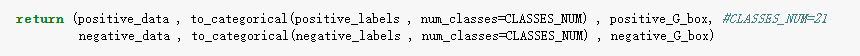

In [10]:
#refer:https://blog.csdn.net/two_vv/article/details/76769860

class Alexnet_finetune(object):
    def __init__(self):
        #迁移参数
        self.learning_rate = 0.001
        self.num_epochs = 1 # 10 一个epoch需要12个小时 crazy!!!
        self.xxx = 18000 #PASCAL VOC所有的数据
        self.dropout_rate = 0.5
        self.classes_num = CLASSES_NUM #20+1
        
        #生成训练数据使用
        self.img_generator = Img_generator()

        #模型可视化 模型保存相关
        #==========
        self.filewriter_path = 'qp/image' #tensorboard使用
        self.checkpoint_path = 'qp/finetune_alexnet' #模型及其参数的保存 持久化
        #==========
        
        #下面是tensorflow部分
        '''
        128不能修改 与PROPOSAL_SIZE保持一致
        None 位置 为batch size
        '''
        
        self.x = tf.placeholder(tf.float32 , shape=[128 , HEIGHT , WIDTH , CHANNEL])
        self.y = tf.placeholder(tf.float32 , shape=[128 , self.classes_num]) #128*21
        self.keep_prob = tf.placeholder(tf.float32) #scalar
        
        self.model = AlexNet_model(self.x , self.keep_prob , self.classes_num)

        self.score = self.model.fc7 #21维概率
        
        #预训练结束之后 提取4096维特征使用
        self.features = self.model.fc6 #为1024维输出 4096维爆显存
            
        #损失函数 交叉熵 softmax
        with tf.name_scope('cross_ent'):
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.score , labels=self.y))
        
        #构造训练过程
        with tf.name_scope('train'):
            self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
            self.train_op = self.optimizer.minimize(self.loss)
            
        #可视化使用
        tf.summary.scalar('cross_entropy' , self.loss)
        
        #精度
        with tf.name_scope('accuracy'):
            self.corrent_pred = tf.equal(tf.argmax(self.score , axis=1) , tf.argmax(self.y , axis=1)) #返回的是最大值的索引
            self.accuracy = tf.reduce_mean(tf.cast(self.corrent_pred , tf.float32))
        
        tf.summary.scalar('accuracy' , self.accuracy)
        
        #merge所有summary 使用tensorboard显示
        self.merged_summary = tf.summary.merge_all() #需要有session时才能起作用
        #tensorboard使用 日志形式 在此文件夹下运行tensorboard
        self.writer = tf.summary.FileWriter(logdir = self.filewriter_path ) #qp/image
        #将模型保存起来 持久模式 以后能够读出使用
        self.saver = tf.train.Saver()
        
        #防止显存溢出添加
        self.resource_threshold_shape_0 = 800 #候选框超过800 将其拆分为两块处理 #1000还是有点大

    def train(self):
        
        '''
        fast rcnn中为batch_size=2张图片
        1张图片中的roi=64
        '''
        def next_batch():
            try:
                positive_train_data , positive_train_labels , negative_train_data , negative_train_labels = self.img_generator.load() #载入batch_size的图像
            except ValueError:
                #ValueError: could not broadcast input array from shape (188,128,3) into shape (188)
                #没找到原因 重新load一张图
                #2008_006489.jpg 出现问题
                positive_train_data , positive_train_labels , negative_train_data , negative_train_labels = next_batch()
            
            return positive_train_data , positive_train_labels , negative_train_data , negative_train_labels , len(positive_train_data) + len(negative_train_data) #最后一个为proposal数量
        
        #fast rcnn中修改为next_roi
        def next_proposal(positive_train_data , positive_train_labels , negative_train_data , negative_train_labels):
            #32正样本 96负样本
            positive_train_data_batch = []
            positive_train_labels_batch = []
            
            negative_train_data_batch = []
            negative_train_labels_batch = []
            
            #paper中正负样本比例
            if len(positive_train_data) == 0:
                #正样本为0
                #全部使用负样本
                negative_proposal_idx = np.random.randint(0 , high=len(negative_train_data) , size=PROPOSAL_SIZE) #128
                
                for k in negative_proposal_idx:
                    negative_train_data_batch.append(negative_train_data[k])
                    negative_train_labels_batch.append(negative_train_labels[k])
                ''''''
                return np.array(negative_train_data_batch) , np.array(negative_train_labels_batch)
                ''''''
            else:
                positive_proposal_idx = np.random.randint(0 , high=len(positive_train_data) , size=PROPOSAL_SIZE_POSITIVE) #32
            
            if len(negative_train_data) == 0:
                #负样本为0
                #全部使用正样本
                positive_proposal_idx = np.random.randint(0 , high=len(positive_train_data) , size=PROPOSAL_SIZE) #128
                
                for j in positive_proposal_idx:
                    positive_train_data_batch.append(positive_train_data[j])
                    positive_train_labels_batch.append(positive_train_labels[j])
                ''''''
                return np.array(positive_train_data_batch) , np.array(positive_train_labels_batch)
                ''''''
            else:
                negative_proposal_idx = np.random.randint(0 , high=len(negative_train_data) , size=PROPOSAL_SIZE_NEGATIVE) #96
            
            #=====================
            #=====================
            #两个else后 会执行到这里
            '''
            此处=========
            
            '''
            for j in positive_proposal_idx:
                positive_train_data_batch.append(positive_train_data[j])
                positive_train_labels_batch.append(positive_train_labels[j])

            for k in negative_proposal_idx:
                negative_train_data_batch.append(negative_train_data[k])
                negative_train_labels_batch.append(negative_train_labels[k])
            
            positive_train_data_batch = np.array(positive_train_data_batch)
            positive_train_labels_batch = np.array(positive_train_labels_batch)
            
            negative_train_data_batch = np.array(negative_train_data_batch) 
            negative_train_labels_batch = np.array(negative_train_labels_batch) 
            
            data_x = np.concatenate((positive_train_data_batch , negative_train_data_batch))
            labels_x = np.concatenate((positive_train_labels_batch , negative_train_labels_batch))
            
            #置乱索引
            shuffle_idx = np.arange(0 , len(data_x))
            np.random.shuffle(shuffle_idx)
            
            return data_x[shuffle_idx] , labels_x[shuffle_idx]
     
    
        with tf.Session() as sess:
            
            if os.path.exists('qp/finetune_alexnet/checkpoint'):
                sess.run(tf.global_variables_initializer())
                self.saver.restore(sess , tf.train.latest_checkpoint('qp/finetune_alexnet/')) #读取模型
                
            else:
                sess.run(tf.global_variables_initializer())

                #计算图放到tensorboard中
                self.writer.add_graph(sess.graph)
            
            for i in range(self.num_epochs): #10
                #一个epoch
                
                for k in range(self.xxx): #18000 所有图片
                    
                    positive_train_data , positive_train_labels , negative_train_data , negative_train_labels , train_proposal_num = next_batch() #选择一张图片

                    #将一张图像中的proposal全部训练一遍
                    iters = train_proposal_num // PROPOSAL_SIZE #训练完所有的proposal需要迭代多少次
                    for j in range(iters):
                        train_images_batch , train_labels_batch = next_proposal(positive_train_data , positive_train_labels , negative_train_data , negative_train_labels) #在选中的一张图片中选择一些候选框
                        #print(train_images_batch.shape , train_labels_batch.shape) #debug

                        losss , _ = sess.run([self.loss , self.train_op] , feed_dict={self.x:train_images_batch , self.y:train_labels_batch , self.keep_prob:self.dropout_rate })

                        #save model
                        #生成训练时的相关数据 上面使用tf.summary.xxx函数的数据
                        
                        #放在这里与放在for-j循环外面是一样的 但是就不能使用train_images_batch train_labels_batch了
                        if j==iters-1 and k%100 == 0: #100张图像写入一次tensorboard
                            merge_summary = sess.run(self.merged_summary , {self.x:train_images_batch , self.y:train_labels_batch , self.keep_prob:1.0 })
                            self.writer.add_summary(merge_summary , i) #写入tenorboard

                        if j == iters - 1:
                            print('epoch:%d/%d img:%d/%d loss:%f' % (i , self.num_epochs , k , self.xxx , losss))

                    if k % 500 == 0: #500张图像保存一次模型
                        checkpoint_name = os.path.join(self.checkpoint_path , 'model_epoch.ckpt')
                        save_path = self.saver.save(sess , checkpoint_name)
                
        self.writer.close()
        
    #使用调优后的alexnet进行特征提取
    def extract_feature(self , proposals_region):
        '''
        proposals_region.shape (count height width 3)
        proposals_region为proposals的具体数据
        '''
        #没有model的保存数据就先训练
        if not os.path.exists('qp/finetune_alexnet/checkpoint'):
            self.train()
            
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            self.saver.restore(sess , tf.train.latest_checkpoint('qp/finetune_alexnet/')) #读取模型整个model的模型参数

            '''
            如果proposals数量没有超过128 进行处理的策略
            
            '''
            proposals_region_cnn_features = []
              
            if len(proposals_region) >= 128:
                
                #拆开获取1024维特征
                ''''''
                #idx_bak=0
                ''''''
                #for idx in range( len(proposals_region) // self.resource_threshold_shape_0):
                #    proposals_region_cnn_features_block = sess.run(self.features , feed_dict={self.x : proposals_region[idx*self.resource_threshold_shape_0 : (idx+1)*self.resource_threshold_shape_0] , self.keep_prob:1.0})
                #    proposals_region_cnn_features.append(proposals_region_cnn_features_block)
                    
                #   idx_bak = idx
                
                #余下的部分（不是整的）
                '''
                先不管下面 将多出128倍数部分的框子扔了
                '''
                #proposals_region_cnn_features_extra = sess.run(self.features , feed_dict={self.x : proposals_region[(idx_bak+1)*self.resource_threshold_shape_0:] , self.keep_prob:1.0})
                #proposals_region_cnn_features.append(proposals_region_cnn_features_extra)
                
                #proposals_region_cnn_features = np.concatenate(proposals_region_cnn_features) #将块的1024维特征合起来
                
                proposals_region_cnn_features = sess.run(self.features , feed_dict={self.x : proposals_region[ : 128] , self.keep_prob:1.0})

                
            else:
                #proposals_region_cnn_features = sess.run(self.features , feed_dict={self.x : proposals_region , self.keep_prob:1.0})
                print('less 128')
                return 0
            
            return np.array(proposals_region_cnn_features)

    def demo(self , path):
        #
        _ , proposals , proposals_region = self.img_generator.one_img_rect_region(path)
        
        return self.extract_feature(proposals_region)

In [11]:
model = Alexnet_finetune()

In [12]:
'''
已经训练结束 不再训练
'''

#model.train()

INFO:tensorflow:Restoring parameters from qp/finetune_alexnet/model_epoch.ckpt
epoch:0/1 img:1/18000 loss:0.621910
epoch:0/1 img:4/18000 loss:0.790692
epoch:0/1 img:7/18000 loss:0.712415
epoch:0/1 img:8/18000 loss:1.022557
epoch:0/1 img:9/18000 loss:0.819536
epoch:0/1 img:12/18000 loss:0.604222
epoch:0/1 img:14/18000 loss:1.160510
epoch:0/1 img:17/18000 loss:1.582408
epoch:0/1 img:21/18000 loss:1.393225
epoch:0/1 img:23/18000 loss:1.062528
epoch:0/1 img:25/18000 loss:1.020448
epoch:0/1 img:26/18000 loss:0.162107
epoch:0/1 img:29/18000 loss:0.709398
epoch:0/1 img:33/18000 loss:1.411468
epoch:0/1 img:34/18000 loss:0.696167
epoch:0/1 img:35/18000 loss:1.534733
epoch:0/1 img:36/18000 loss:1.555804
epoch:0/1 img:37/18000 loss:1.062507
epoch:0/1 img:41/18000 loss:0.655553
epoch:0/1 img:45/18000 loss:1.649921
epoch:0/1 img:50/18000 loss:1.242623
epoch:0/1 img:53/18000 loss:0.243174
epoch:0/1 img:54/18000 loss:0.788011
epoch:0/1 img:55/18000 loss:1.357198
epoch:0/1 img:56/18000 loss:1.566822
e

epoch:0/1 img:494/18000 loss:1.139551
epoch:0/1 img:499/18000 loss:1.139922
epoch:0/1 img:501/18000 loss:0.716889
epoch:0/1 img:503/18000 loss:0.936439
epoch:0/1 img:504/18000 loss:1.067134
epoch:0/1 img:505/18000 loss:0.662293
epoch:0/1 img:508/18000 loss:1.445862
epoch:0/1 img:510/18000 loss:1.181693
epoch:0/1 img:512/18000 loss:1.542001
epoch:0/1 img:513/18000 loss:0.106681
epoch:0/1 img:516/18000 loss:0.199115
epoch:0/1 img:517/18000 loss:1.378381
epoch:0/1 img:518/18000 loss:0.666651
epoch:0/1 img:519/18000 loss:0.850110
epoch:0/1 img:520/18000 loss:1.437469
epoch:0/1 img:522/18000 loss:1.373992
epoch:0/1 img:523/18000 loss:0.788341
epoch:0/1 img:524/18000 loss:1.625086
epoch:0/1 img:525/18000 loss:0.668401
epoch:0/1 img:527/18000 loss:1.536370
epoch:0/1 img:529/18000 loss:0.634446
epoch:0/1 img:533/18000 loss:1.005343
epoch:0/1 img:534/18000 loss:0.695540
epoch:0/1 img:535/18000 loss:0.796479
epoch:0/1 img:537/18000 loss:1.192349
epoch:0/1 img:538/18000 loss:1.412916
epoch:0/1 im

epoch:0/1 img:903/18000 loss:0.263815
epoch:0/1 img:904/18000 loss:0.860562
epoch:0/1 img:905/18000 loss:1.484156
epoch:0/1 img:907/18000 loss:1.474328
epoch:0/1 img:908/18000 loss:0.204722
epoch:0/1 img:909/18000 loss:1.288923
epoch:0/1 img:912/18000 loss:0.257532
epoch:0/1 img:913/18000 loss:0.945103
epoch:0/1 img:914/18000 loss:0.237279
epoch:0/1 img:916/18000 loss:1.576997
epoch:0/1 img:918/18000 loss:1.514346
epoch:0/1 img:922/18000 loss:0.698436
epoch:0/1 img:924/18000 loss:0.239048
epoch:0/1 img:926/18000 loss:0.209796
epoch:0/1 img:928/18000 loss:0.703566
epoch:0/1 img:929/18000 loss:0.691395
epoch:0/1 img:934/18000 loss:0.195016
epoch:0/1 img:935/18000 loss:1.342186
epoch:0/1 img:937/18000 loss:1.025419
epoch:0/1 img:939/18000 loss:1.159864
epoch:0/1 img:940/18000 loss:0.684646
epoch:0/1 img:941/18000 loss:0.665343
epoch:0/1 img:942/18000 loss:1.599130
epoch:0/1 img:944/18000 loss:1.582451
epoch:0/1 img:945/18000 loss:1.432386
epoch:0/1 img:946/18000 loss:0.740525
epoch:0/1 im

epoch:0/1 img:1349/18000 loss:1.078124
epoch:0/1 img:1354/18000 loss:2.070964
epoch:0/1 img:1355/18000 loss:0.655195
epoch:0/1 img:1357/18000 loss:1.050265
epoch:0/1 img:1360/18000 loss:1.124848
epoch:0/1 img:1363/18000 loss:0.648197
epoch:0/1 img:1364/18000 loss:1.431872
epoch:0/1 img:1365/18000 loss:0.793680
epoch:0/1 img:1373/18000 loss:1.086156
epoch:0/1 img:1374/18000 loss:1.349345
epoch:0/1 img:1376/18000 loss:1.497090
epoch:0/1 img:1378/18000 loss:0.165928
epoch:0/1 img:1379/18000 loss:1.333135
epoch:0/1 img:1381/18000 loss:0.644108
epoch:0/1 img:1387/18000 loss:1.154824
epoch:0/1 img:1388/18000 loss:0.627885
epoch:0/1 img:1393/18000 loss:1.403297
epoch:0/1 img:1395/18000 loss:1.130656
epoch:0/1 img:1397/18000 loss:1.101019
epoch:0/1 img:1398/18000 loss:3.397846
epoch:0/1 img:1400/18000 loss:0.825153
epoch:0/1 img:1401/18000 loss:1.285259
epoch:0/1 img:1402/18000 loss:1.300319
epoch:0/1 img:1403/18000 loss:0.691503
epoch:0/1 img:1404/18000 loss:0.714936
epoch:0/1 img:1406/18000 

epoch:0/1 img:1788/18000 loss:1.704491
epoch:0/1 img:1789/18000 loss:0.721529
epoch:0/1 img:1792/18000 loss:0.691834
epoch:0/1 img:1797/18000 loss:0.768505
epoch:0/1 img:1798/18000 loss:0.226275
epoch:0/1 img:1799/18000 loss:1.174381
epoch:0/1 img:1801/18000 loss:1.323936
epoch:0/1 img:1802/18000 loss:1.176432
epoch:0/1 img:1803/18000 loss:1.458678
epoch:0/1 img:1805/18000 loss:1.226927
epoch:0/1 img:1808/18000 loss:1.244158
epoch:0/1 img:1809/18000 loss:0.238199
epoch:0/1 img:1810/18000 loss:1.106520
epoch:0/1 img:1811/18000 loss:0.251393
epoch:0/1 img:1812/18000 loss:0.756769
epoch:0/1 img:1816/18000 loss:0.917051
epoch:0/1 img:1818/18000 loss:0.746948
epoch:0/1 img:1820/18000 loss:1.623262
epoch:0/1 img:1824/18000 loss:1.452304
epoch:0/1 img:1825/18000 loss:0.752373
epoch:0/1 img:1827/18000 loss:1.198473
epoch:0/1 img:1831/18000 loss:0.322648
epoch:0/1 img:1832/18000 loss:0.764033
epoch:0/1 img:1833/18000 loss:0.960081
epoch:0/1 img:1835/18000 loss:1.247806
epoch:0/1 img:1838/18000 

epoch:0/1 img:2231/18000 loss:0.725004
epoch:0/1 img:2237/18000 loss:0.713719
epoch:0/1 img:2240/18000 loss:1.110376
epoch:0/1 img:2242/18000 loss:0.939103
epoch:0/1 img:2249/18000 loss:0.709724
epoch:0/1 img:2250/18000 loss:0.856994
epoch:0/1 img:2252/18000 loss:0.682444
epoch:0/1 img:2254/18000 loss:0.849510
epoch:0/1 img:2256/18000 loss:1.351440
epoch:0/1 img:2262/18000 loss:0.662268
epoch:0/1 img:2265/18000 loss:1.118363
epoch:0/1 img:2266/18000 loss:1.208393
epoch:0/1 img:2269/18000 loss:1.064482
epoch:0/1 img:2270/18000 loss:1.966348
epoch:0/1 img:2271/18000 loss:1.494111
epoch:0/1 img:2272/18000 loss:1.230870
epoch:0/1 img:2273/18000 loss:1.319465
epoch:0/1 img:2274/18000 loss:1.402164
epoch:0/1 img:2276/18000 loss:1.469098
epoch:0/1 img:2277/18000 loss:0.729405
epoch:0/1 img:2278/18000 loss:0.670874
epoch:0/1 img:2281/18000 loss:0.984606
epoch:0/1 img:2282/18000 loss:1.448454
epoch:0/1 img:2284/18000 loss:1.071046
epoch:0/1 img:2285/18000 loss:0.671626
epoch:0/1 img:2286/18000 

epoch:0/1 img:2662/18000 loss:1.339845
epoch:0/1 img:2664/18000 loss:1.213171
epoch:0/1 img:2665/18000 loss:1.365499
epoch:0/1 img:2666/18000 loss:1.470628
epoch:0/1 img:2667/18000 loss:0.713979
epoch:0/1 img:2668/18000 loss:1.177724
epoch:0/1 img:2669/18000 loss:1.236274
epoch:0/1 img:2670/18000 loss:1.230902
epoch:0/1 img:2671/18000 loss:0.903798
epoch:0/1 img:2672/18000 loss:0.734659
epoch:0/1 img:2673/18000 loss:0.252739
epoch:0/1 img:2675/18000 loss:0.241656
epoch:0/1 img:2678/18000 loss:0.254547
epoch:0/1 img:2679/18000 loss:1.109123
epoch:0/1 img:2681/18000 loss:0.893022
epoch:0/1 img:2682/18000 loss:1.374834
epoch:0/1 img:2684/18000 loss:1.330936
epoch:0/1 img:2686/18000 loss:1.525476
epoch:0/1 img:2687/18000 loss:1.578134
epoch:0/1 img:2690/18000 loss:1.402270
epoch:0/1 img:2692/18000 loss:1.382100
epoch:0/1 img:2694/18000 loss:1.328141
epoch:0/1 img:2696/18000 loss:0.943788
epoch:0/1 img:2697/18000 loss:1.401724
epoch:0/1 img:2699/18000 loss:0.848886
epoch:0/1 img:2704/18000 

epoch:0/1 img:3095/18000 loss:1.214457
epoch:0/1 img:3098/18000 loss:1.420684
epoch:0/1 img:3099/18000 loss:0.672870
epoch:0/1 img:3105/18000 loss:0.209526
epoch:0/1 img:3108/18000 loss:0.678254
epoch:0/1 img:3110/18000 loss:1.411865
epoch:0/1 img:3112/18000 loss:1.344301
epoch:0/1 img:3113/18000 loss:1.355550
epoch:0/1 img:3116/18000 loss:1.395205
epoch:0/1 img:3117/18000 loss:1.132199
epoch:0/1 img:3118/18000 loss:0.817691
epoch:0/1 img:3119/18000 loss:1.000516
epoch:0/1 img:3120/18000 loss:0.672110
epoch:0/1 img:3121/18000 loss:1.205187
epoch:0/1 img:3125/18000 loss:1.037158
epoch:0/1 img:3130/18000 loss:1.556610
epoch:0/1 img:3133/18000 loss:0.206582
epoch:0/1 img:3138/18000 loss:0.594877
epoch:0/1 img:3140/18000 loss:1.664294
epoch:0/1 img:3141/18000 loss:0.790242
epoch:0/1 img:3142/18000 loss:1.392426
epoch:0/1 img:3143/18000 loss:1.102889
epoch:0/1 img:3144/18000 loss:1.437415
epoch:0/1 img:3145/18000 loss:1.229299
epoch:0/1 img:3146/18000 loss:0.913676
epoch:0/1 img:3151/18000 

epoch:0/1 img:3508/18000 loss:0.882695
epoch:0/1 img:3510/18000 loss:0.239096
epoch:0/1 img:3513/18000 loss:0.682386
epoch:0/1 img:3517/18000 loss:1.389104
epoch:0/1 img:3518/18000 loss:0.638797
epoch:0/1 img:3519/18000 loss:0.664032
epoch:0/1 img:3520/18000 loss:1.476796
epoch:0/1 img:3521/18000 loss:1.602932
epoch:0/1 img:3523/18000 loss:0.871589
epoch:0/1 img:3524/18000 loss:0.721271
epoch:0/1 img:3525/18000 loss:0.724203
epoch:0/1 img:3526/18000 loss:1.412812
epoch:0/1 img:3530/18000 loss:0.293927
epoch:0/1 img:3531/18000 loss:1.366096
epoch:0/1 img:3532/18000 loss:1.236297
epoch:0/1 img:3535/18000 loss:1.506087
epoch:0/1 img:3538/18000 loss:0.706991
epoch:0/1 img:3539/18000 loss:1.417286
epoch:0/1 img:3540/18000 loss:1.510182
epoch:0/1 img:3541/18000 loss:1.379909
epoch:0/1 img:3546/18000 loss:0.251132
epoch:0/1 img:3547/18000 loss:1.179985
epoch:0/1 img:3548/18000 loss:1.016313
epoch:0/1 img:3550/18000 loss:1.361276
epoch:0/1 img:3551/18000 loss:1.218235
epoch:0/1 img:3552/18000 

epoch:0/1 img:3996/18000 loss:1.344419
epoch:0/1 img:3998/18000 loss:0.694430
epoch:0/1 img:4001/18000 loss:1.707502
epoch:0/1 img:4002/18000 loss:0.697622
epoch:0/1 img:4005/18000 loss:1.314286
epoch:0/1 img:4006/18000 loss:0.722232
epoch:0/1 img:4008/18000 loss:1.226752
epoch:0/1 img:4009/18000 loss:1.312129
epoch:0/1 img:4010/18000 loss:0.246559
epoch:0/1 img:4012/18000 loss:0.740240
epoch:0/1 img:4019/18000 loss:1.299147
epoch:0/1 img:4021/18000 loss:1.435983
epoch:0/1 img:4025/18000 loss:0.683392
epoch:0/1 img:4026/18000 loss:1.090384
epoch:0/1 img:4030/18000 loss:0.676220
epoch:0/1 img:4031/18000 loss:0.692159
epoch:0/1 img:4032/18000 loss:1.592035
epoch:0/1 img:4036/18000 loss:0.662937
epoch:0/1 img:4038/18000 loss:1.269237
epoch:0/1 img:4039/18000 loss:0.832166
epoch:0/1 img:4041/18000 loss:0.788707
epoch:0/1 img:4042/18000 loss:1.288413
epoch:0/1 img:4043/18000 loss:1.101876
epoch:0/1 img:4044/18000 loss:0.652962
epoch:0/1 img:4045/18000 loss:0.792476
epoch:0/1 img:4047/18000 

epoch:0/1 img:4424/18000 loss:0.810941
epoch:0/1 img:4426/18000 loss:0.708127
epoch:0/1 img:4429/18000 loss:1.176656
epoch:0/1 img:4430/18000 loss:0.265701
epoch:0/1 img:4431/18000 loss:0.909748
epoch:0/1 img:4432/18000 loss:1.210626
epoch:0/1 img:4433/18000 loss:0.686686
epoch:0/1 img:4434/18000 loss:0.678827
epoch:0/1 img:4436/18000 loss:1.054744
epoch:0/1 img:4441/18000 loss:1.602428
epoch:0/1 img:4442/18000 loss:1.116726
epoch:0/1 img:4444/18000 loss:0.676455
epoch:0/1 img:4448/18000 loss:1.003909
epoch:0/1 img:4449/18000 loss:1.380511
epoch:0/1 img:4451/18000 loss:1.348918
epoch:0/1 img:4454/18000 loss:1.557811
epoch:0/1 img:4455/18000 loss:1.485936
epoch:0/1 img:4456/18000 loss:0.711868
epoch:0/1 img:4458/18000 loss:0.820173
epoch:0/1 img:4460/18000 loss:1.123339
epoch:0/1 img:4465/18000 loss:0.693241
epoch:0/1 img:4466/18000 loss:0.704467
epoch:0/1 img:4467/18000 loss:1.306849
epoch:0/1 img:4470/18000 loss:0.260397
epoch:0/1 img:4471/18000 loss:1.260254
epoch:0/1 img:4476/18000 

epoch:0/1 img:4835/18000 loss:1.400375
epoch:0/1 img:4838/18000 loss:0.692361
epoch:0/1 img:4840/18000 loss:3.828682
epoch:0/1 img:4841/18000 loss:1.191665
epoch:0/1 img:4842/18000 loss:0.726320
epoch:0/1 img:4843/18000 loss:0.721183
epoch:0/1 img:4845/18000 loss:0.295520
epoch:0/1 img:4847/18000 loss:1.155782
epoch:0/1 img:4853/18000 loss:0.291754
epoch:0/1 img:4855/18000 loss:0.699947
epoch:0/1 img:4856/18000 loss:1.526996
epoch:0/1 img:4858/18000 loss:1.575150
epoch:0/1 img:4859/18000 loss:1.422417
epoch:0/1 img:4860/18000 loss:1.600248
epoch:0/1 img:4861/18000 loss:1.408858
epoch:0/1 img:4864/18000 loss:1.409940
epoch:0/1 img:4868/18000 loss:1.449483
epoch:0/1 img:4870/18000 loss:1.397960
epoch:0/1 img:4871/18000 loss:1.487680
epoch:0/1 img:4873/18000 loss:1.338368
epoch:0/1 img:4876/18000 loss:0.720213
epoch:0/1 img:4879/18000 loss:1.369288
epoch:0/1 img:4881/18000 loss:1.582762
epoch:0/1 img:4883/18000 loss:0.245351
epoch:0/1 img:4884/18000 loss:1.153160
epoch:0/1 img:4888/18000 

epoch:0/1 img:5271/18000 loss:0.728382
epoch:0/1 img:5274/18000 loss:1.439063
epoch:0/1 img:5278/18000 loss:1.492520
epoch:0/1 img:5280/18000 loss:1.463010
epoch:0/1 img:5283/18000 loss:1.050853
epoch:0/1 img:5284/18000 loss:1.331333
epoch:0/1 img:5286/18000 loss:0.719843
epoch:0/1 img:5288/18000 loss:1.099942
epoch:0/1 img:5289/18000 loss:1.141406
epoch:0/1 img:5291/18000 loss:1.299151
epoch:0/1 img:5293/18000 loss:1.262890
epoch:0/1 img:5296/18000 loss:1.004360
epoch:0/1 img:5301/18000 loss:0.772499
epoch:0/1 img:5302/18000 loss:0.995663
epoch:0/1 img:5303/18000 loss:1.571285
epoch:0/1 img:5305/18000 loss:0.238097
epoch:0/1 img:5306/18000 loss:1.075177
epoch:0/1 img:5308/18000 loss:0.236285
epoch:0/1 img:5311/18000 loss:1.797097
epoch:0/1 img:5313/18000 loss:0.648649
epoch:0/1 img:5318/18000 loss:1.297841
epoch:0/1 img:5320/18000 loss:1.069809
epoch:0/1 img:5322/18000 loss:0.770535
epoch:0/1 img:5323/18000 loss:4.271526
epoch:0/1 img:5325/18000 loss:1.050712
epoch:0/1 img:5327/18000 

epoch:0/1 img:5722/18000 loss:1.164253
epoch:0/1 img:5723/18000 loss:1.256996
epoch:0/1 img:5728/18000 loss:0.964703
epoch:0/1 img:5731/18000 loss:0.736018
epoch:0/1 img:5737/18000 loss:1.027992
epoch:0/1 img:5739/18000 loss:0.745271
epoch:0/1 img:5740/18000 loss:0.688868
epoch:0/1 img:5741/18000 loss:1.168107
epoch:0/1 img:5742/18000 loss:1.531750
epoch:0/1 img:5745/18000 loss:1.102221
epoch:0/1 img:5746/18000 loss:1.455966
epoch:0/1 img:5747/18000 loss:0.203564
epoch:0/1 img:5748/18000 loss:0.705960
epoch:0/1 img:5750/18000 loss:0.895969
epoch:0/1 img:5751/18000 loss:0.239473
epoch:0/1 img:5752/18000 loss:0.247853
epoch:0/1 img:5753/18000 loss:1.312588
epoch:0/1 img:5754/18000 loss:1.358118
epoch:0/1 img:5758/18000 loss:0.696655
epoch:0/1 img:5761/18000 loss:0.749549
epoch:0/1 img:5762/18000 loss:0.730194
epoch:0/1 img:5764/18000 loss:0.224006
epoch:0/1 img:5765/18000 loss:0.672299
epoch:0/1 img:5766/18000 loss:1.507936
epoch:0/1 img:5767/18000 loss:6.683779
epoch:0/1 img:5769/18000 

epoch:0/1 img:6157/18000 loss:1.234757
epoch:0/1 img:6159/18000 loss:1.008143
epoch:0/1 img:6161/18000 loss:0.760800
epoch:0/1 img:6162/18000 loss:0.306815
epoch:0/1 img:6163/18000 loss:0.746359
epoch:0/1 img:6170/18000 loss:1.154995
epoch:0/1 img:6171/18000 loss:0.969182
epoch:0/1 img:6173/18000 loss:0.755425
epoch:0/1 img:6175/18000 loss:1.283657
epoch:0/1 img:6176/18000 loss:1.383564
epoch:0/1 img:6177/18000 loss:0.919922
epoch:0/1 img:6178/18000 loss:1.610918
epoch:0/1 img:6181/18000 loss:1.421047
epoch:0/1 img:6182/18000 loss:1.186467
epoch:0/1 img:6183/18000 loss:0.777405
epoch:0/1 img:6186/18000 loss:1.034101
epoch:0/1 img:6187/18000 loss:1.154605
epoch:0/1 img:6189/18000 loss:1.258669
epoch:0/1 img:6190/18000 loss:1.287368
epoch:0/1 img:6191/18000 loss:1.409374
epoch:0/1 img:6193/18000 loss:1.244242
epoch:0/1 img:6194/18000 loss:1.421210
epoch:0/1 img:6195/18000 loss:0.706921
epoch:0/1 img:6196/18000 loss:1.296067
epoch:0/1 img:6199/18000 loss:1.593176
epoch:0/1 img:6200/18000 

epoch:0/1 img:6577/18000 loss:0.765802
epoch:0/1 img:6578/18000 loss:0.743903
epoch:0/1 img:6579/18000 loss:1.191231
epoch:0/1 img:6581/18000 loss:1.590829
epoch:0/1 img:6583/18000 loss:1.084119
epoch:0/1 img:6586/18000 loss:0.765810
epoch:0/1 img:6587/18000 loss:0.727956
epoch:0/1 img:6588/18000 loss:0.755699
epoch:0/1 img:6594/18000 loss:0.748184
epoch:0/1 img:6596/18000 loss:0.738542
epoch:0/1 img:6600/18000 loss:1.411173
epoch:0/1 img:6601/18000 loss:1.628527
epoch:0/1 img:6602/18000 loss:1.413952
epoch:0/1 img:6607/18000 loss:1.217134
epoch:0/1 img:6608/18000 loss:0.255600
epoch:0/1 img:6609/18000 loss:0.953243
epoch:0/1 img:6612/18000 loss:1.388188
epoch:0/1 img:6614/18000 loss:0.219321
epoch:0/1 img:6615/18000 loss:0.914550
epoch:0/1 img:6616/18000 loss:1.408110
epoch:0/1 img:6617/18000 loss:1.669534
epoch:0/1 img:6618/18000 loss:1.418078
epoch:0/1 img:6626/18000 loss:1.076588
epoch:0/1 img:6628/18000 loss:1.547916
epoch:0/1 img:6630/18000 loss:0.659646
epoch:0/1 img:6632/18000 

epoch:0/1 img:6971/18000 loss:1.274994
epoch:0/1 img:6972/18000 loss:0.299668
epoch:0/1 img:6975/18000 loss:0.716762
epoch:0/1 img:6976/18000 loss:1.064427
epoch:0/1 img:6977/18000 loss:0.709264
epoch:0/1 img:6979/18000 loss:1.594670
epoch:0/1 img:6981/18000 loss:1.548068
epoch:0/1 img:6986/18000 loss:0.718574
epoch:0/1 img:6988/18000 loss:0.272142
epoch:0/1 img:6989/18000 loss:1.005486
epoch:0/1 img:6991/18000 loss:1.133972
epoch:0/1 img:6992/18000 loss:0.290592
epoch:0/1 img:6993/18000 loss:1.285234
epoch:0/1 img:6995/18000 loss:0.171455
epoch:0/1 img:7000/18000 loss:0.211896
epoch:0/1 img:7002/18000 loss:1.100356
epoch:0/1 img:7003/18000 loss:0.682544
epoch:0/1 img:7004/18000 loss:0.926943
epoch:0/1 img:7006/18000 loss:1.127626
epoch:0/1 img:7008/18000 loss:1.387446
epoch:0/1 img:7010/18000 loss:0.698947
epoch:0/1 img:7015/18000 loss:0.940008
epoch:0/1 img:7017/18000 loss:3.790940
epoch:0/1 img:7020/18000 loss:1.701957
epoch:0/1 img:7022/18000 loss:1.328979
epoch:0/1 img:7024/18000 

epoch:0/1 img:7395/18000 loss:0.925572
epoch:0/1 img:7399/18000 loss:1.356891
epoch:0/1 img:7400/18000 loss:1.242441
epoch:0/1 img:7401/18000 loss:0.704587
epoch:0/1 img:7404/18000 loss:0.914711
epoch:0/1 img:7406/18000 loss:1.536188
epoch:0/1 img:7407/18000 loss:0.746233
epoch:0/1 img:7410/18000 loss:1.591564
epoch:0/1 img:7412/18000 loss:1.642925
epoch:0/1 img:7416/18000 loss:1.281414
epoch:0/1 img:7419/18000 loss:1.465916
epoch:0/1 img:7420/18000 loss:1.343312
epoch:0/1 img:7428/18000 loss:0.752522
epoch:0/1 img:7429/18000 loss:1.173234
epoch:0/1 img:7430/18000 loss:0.721161
epoch:0/1 img:7437/18000 loss:1.246404
epoch:0/1 img:7438/18000 loss:1.231407
epoch:0/1 img:7439/18000 loss:1.070589
epoch:0/1 img:7441/18000 loss:0.745090
epoch:0/1 img:7443/18000 loss:1.301932
epoch:0/1 img:7451/18000 loss:0.723699
epoch:0/1 img:7456/18000 loss:0.239305
epoch:0/1 img:7458/18000 loss:1.055734
epoch:0/1 img:7459/18000 loss:1.445466
epoch:0/1 img:7463/18000 loss:0.733816
epoch:0/1 img:7464/18000 

epoch:0/1 img:7820/18000 loss:1.233683
epoch:0/1 img:7821/18000 loss:1.541094
epoch:0/1 img:7823/18000 loss:0.802881
epoch:0/1 img:7825/18000 loss:1.128723
epoch:0/1 img:7827/18000 loss:0.253332
epoch:0/1 img:7828/18000 loss:0.733884
epoch:0/1 img:7829/18000 loss:0.762289
epoch:0/1 img:7830/18000 loss:0.769298
epoch:0/1 img:7833/18000 loss:1.244937
epoch:0/1 img:7834/18000 loss:1.144511
epoch:0/1 img:7837/18000 loss:0.773137
epoch:0/1 img:7839/18000 loss:1.264163
epoch:0/1 img:7840/18000 loss:0.762100
epoch:0/1 img:7841/18000 loss:1.218457
epoch:0/1 img:7842/18000 loss:1.116497
epoch:0/1 img:7844/18000 loss:0.754682
epoch:0/1 img:7846/18000 loss:1.052733
epoch:0/1 img:7847/18000 loss:0.191007
epoch:0/1 img:7849/18000 loss:1.044237
epoch:0/1 img:7850/18000 loss:1.396832
epoch:0/1 img:7853/18000 loss:1.368240
epoch:0/1 img:7856/18000 loss:0.836760
epoch:0/1 img:7858/18000 loss:1.209236
epoch:0/1 img:7860/18000 loss:1.232272
epoch:0/1 img:7861/18000 loss:1.446206
epoch:0/1 img:7864/18000 

epoch:0/1 img:8275/18000 loss:0.777090
epoch:0/1 img:8278/18000 loss:1.231033
epoch:0/1 img:8280/18000 loss:1.037361
epoch:0/1 img:8283/18000 loss:0.263536
epoch:0/1 img:8285/18000 loss:1.586565
epoch:0/1 img:8286/18000 loss:0.178216
epoch:0/1 img:8289/18000 loss:0.750658
epoch:0/1 img:8291/18000 loss:0.165861
epoch:0/1 img:8292/18000 loss:0.746515
epoch:0/1 img:8296/18000 loss:0.981645
epoch:0/1 img:8299/18000 loss:1.155118
epoch:0/1 img:8300/18000 loss:1.057616
epoch:0/1 img:8301/18000 loss:1.284010
epoch:0/1 img:8302/18000 loss:0.723728
epoch:0/1 img:8303/18000 loss:0.738241
epoch:0/1 img:8304/18000 loss:0.235526
epoch:0/1 img:8305/18000 loss:0.721593
epoch:0/1 img:8306/18000 loss:1.451926
epoch:0/1 img:8307/18000 loss:1.131050
epoch:0/1 img:8309/18000 loss:0.710818
epoch:0/1 img:8310/18000 loss:1.327542
epoch:0/1 img:8314/18000 loss:0.196956
epoch:0/1 img:8316/18000 loss:0.768323
epoch:0/1 img:8317/18000 loss:1.939711
epoch:0/1 img:8319/18000 loss:1.028782
epoch:0/1 img:8321/18000 

epoch:0/1 img:8691/18000 loss:1.492476
epoch:0/1 img:8693/18000 loss:0.854503
epoch:0/1 img:8695/18000 loss:0.746743
epoch:0/1 img:8696/18000 loss:1.374001
epoch:0/1 img:8699/18000 loss:2.517110
epoch:0/1 img:8700/18000 loss:0.724408
epoch:0/1 img:8701/18000 loss:1.334242
epoch:0/1 img:8703/18000 loss:0.739390
epoch:0/1 img:8704/18000 loss:0.863708
epoch:0/1 img:8705/18000 loss:1.221391
epoch:0/1 img:8707/18000 loss:0.718401
epoch:0/1 img:8716/18000 loss:0.841637
epoch:0/1 img:8718/18000 loss:1.385728
epoch:0/1 img:8720/18000 loss:1.201251
epoch:0/1 img:8721/18000 loss:1.520602
epoch:0/1 img:8727/18000 loss:0.721921
epoch:0/1 img:8728/18000 loss:1.128661
epoch:0/1 img:8731/18000 loss:1.475814
epoch:0/1 img:8735/18000 loss:0.194361
epoch:0/1 img:8736/18000 loss:0.118396
epoch:0/1 img:8738/18000 loss:1.926709
epoch:0/1 img:8740/18000 loss:1.285334
epoch:0/1 img:8741/18000 loss:0.676219
epoch:0/1 img:8742/18000 loss:0.251624
epoch:0/1 img:8745/18000 loss:1.648511
epoch:0/1 img:8747/18000 

epoch:0/1 img:9124/18000 loss:1.448321
epoch:0/1 img:9128/18000 loss:1.705122
epoch:0/1 img:9129/18000 loss:1.579163
epoch:0/1 img:9132/18000 loss:0.302757
epoch:0/1 img:9134/18000 loss:1.274807
epoch:0/1 img:9136/18000 loss:1.001050
epoch:0/1 img:9137/18000 loss:0.734407
epoch:0/1 img:9138/18000 loss:0.732681
epoch:0/1 img:9139/18000 loss:1.031079
epoch:0/1 img:9140/18000 loss:0.285495
epoch:0/1 img:9141/18000 loss:1.407027
epoch:0/1 img:9142/18000 loss:0.871809
epoch:0/1 img:9143/18000 loss:1.083246
epoch:0/1 img:9144/18000 loss:1.595681
epoch:0/1 img:9145/18000 loss:0.222674
epoch:0/1 img:9146/18000 loss:1.095515
epoch:0/1 img:9149/18000 loss:1.142757
epoch:0/1 img:9150/18000 loss:1.448896
epoch:0/1 img:9151/18000 loss:1.576209
epoch:0/1 img:9153/18000 loss:1.177495
epoch:0/1 img:9154/18000 loss:1.159958
epoch:0/1 img:9155/18000 loss:0.235421
epoch:0/1 img:9157/18000 loss:1.542619
epoch:0/1 img:9161/18000 loss:1.879181
epoch:0/1 img:9162/18000 loss:1.167774
epoch:0/1 img:9163/18000 

epoch:0/1 img:9558/18000 loss:0.805500
epoch:0/1 img:9560/18000 loss:1.570032
epoch:0/1 img:9561/18000 loss:1.445929
epoch:0/1 img:9562/18000 loss:0.728218
epoch:0/1 img:9563/18000 loss:0.249411
epoch:0/1 img:9564/18000 loss:0.246021
epoch:0/1 img:9565/18000 loss:0.963635
epoch:0/1 img:9567/18000 loss:0.251116
epoch:0/1 img:9568/18000 loss:0.719975
epoch:0/1 img:9569/18000 loss:1.645197
epoch:0/1 img:9570/18000 loss:1.136882
epoch:0/1 img:9572/18000 loss:1.211668
epoch:0/1 img:9573/18000 loss:0.853288
epoch:0/1 img:9575/18000 loss:0.708921
epoch:0/1 img:9576/18000 loss:1.236520
epoch:0/1 img:9578/18000 loss:0.876641
epoch:0/1 img:9581/18000 loss:1.024842
epoch:0/1 img:9582/18000 loss:0.227896
epoch:0/1 img:9583/18000 loss:1.276060
epoch:0/1 img:9586/18000 loss:0.991814
epoch:0/1 img:9591/18000 loss:1.486239
epoch:0/1 img:9595/18000 loss:0.703502
epoch:0/1 img:9596/18000 loss:0.255173
epoch:0/1 img:9597/18000 loss:1.143374
epoch:0/1 img:9603/18000 loss:0.939650
epoch:0/1 img:9604/18000 

epoch:0/1 img:9987/18000 loss:1.035525
epoch:0/1 img:9988/18000 loss:0.972099
epoch:0/1 img:9990/18000 loss:0.726169
epoch:0/1 img:9991/18000 loss:0.944183
epoch:0/1 img:9992/18000 loss:0.236884
epoch:0/1 img:9994/18000 loss:1.438133
epoch:0/1 img:9996/18000 loss:1.065745
epoch:0/1 img:10000/18000 loss:0.691593
epoch:0/1 img:10001/18000 loss:0.240487
epoch:0/1 img:10004/18000 loss:0.243386
epoch:0/1 img:10005/18000 loss:1.126329
epoch:0/1 img:10007/18000 loss:1.054467
epoch:0/1 img:10008/18000 loss:1.555827
epoch:0/1 img:10012/18000 loss:0.704320
epoch:0/1 img:10013/18000 loss:1.229498
epoch:0/1 img:10014/18000 loss:1.079171
epoch:0/1 img:10015/18000 loss:1.554037
epoch:0/1 img:10020/18000 loss:1.359800
epoch:0/1 img:10021/18000 loss:0.889837
epoch:0/1 img:10024/18000 loss:0.907542
epoch:0/1 img:10025/18000 loss:1.350435
epoch:0/1 img:10026/18000 loss:0.723992
epoch:0/1 img:10027/18000 loss:0.225651
epoch:0/1 img:10030/18000 loss:0.959040
epoch:0/1 img:10032/18000 loss:0.895222
epoch:0

epoch:0/1 img:10420/18000 loss:1.224271
epoch:0/1 img:10421/18000 loss:0.727482
epoch:0/1 img:10423/18000 loss:1.545379
epoch:0/1 img:10424/18000 loss:1.219805
epoch:0/1 img:10429/18000 loss:1.169207
epoch:0/1 img:10431/18000 loss:0.239038
epoch:0/1 img:10435/18000 loss:1.007293
epoch:0/1 img:10436/18000 loss:1.247995
epoch:0/1 img:10443/18000 loss:1.567972
epoch:0/1 img:10446/18000 loss:0.723686
epoch:0/1 img:10448/18000 loss:1.232756
epoch:0/1 img:10449/18000 loss:0.747884
epoch:0/1 img:10452/18000 loss:1.191705
epoch:0/1 img:10453/18000 loss:1.231796
epoch:0/1 img:10454/18000 loss:1.037872
epoch:0/1 img:10462/18000 loss:1.531889
epoch:0/1 img:10465/18000 loss:1.799735
epoch:0/1 img:10471/18000 loss:1.089343
epoch:0/1 img:10473/18000 loss:0.730017
epoch:0/1 img:10474/18000 loss:1.285752
epoch:0/1 img:10475/18000 loss:1.486092
epoch:0/1 img:10477/18000 loss:0.223852
epoch:0/1 img:10478/18000 loss:1.002107
epoch:0/1 img:10484/18000 loss:0.756051
epoch:0/1 img:10486/18000 loss:0.720180


epoch:0/1 img:10843/18000 loss:1.264201
epoch:0/1 img:10845/18000 loss:1.554706
epoch:0/1 img:10847/18000 loss:1.728778
epoch:0/1 img:10850/18000 loss:0.700534
epoch:0/1 img:10851/18000 loss:0.719320
epoch:0/1 img:10853/18000 loss:0.919327
epoch:0/1 img:10855/18000 loss:1.345226
epoch:0/1 img:10856/18000 loss:0.758126
epoch:0/1 img:10859/18000 loss:1.207735
epoch:0/1 img:10860/18000 loss:0.760428
epoch:0/1 img:10863/18000 loss:0.745310
epoch:0/1 img:10864/18000 loss:0.732797
epoch:0/1 img:10867/18000 loss:1.538995
epoch:0/1 img:10868/18000 loss:1.138382
epoch:0/1 img:10869/18000 loss:0.740194
epoch:0/1 img:10872/18000 loss:1.218191
epoch:0/1 img:10873/18000 loss:0.718277
epoch:0/1 img:10874/18000 loss:0.746019
epoch:0/1 img:10877/18000 loss:0.719974
epoch:0/1 img:10879/18000 loss:1.503024
epoch:0/1 img:10880/18000 loss:1.424827
epoch:0/1 img:10881/18000 loss:0.709641
epoch:0/1 img:10882/18000 loss:1.458483
epoch:0/1 img:10884/18000 loss:0.711073
epoch:0/1 img:10885/18000 loss:1.192365


epoch:0/1 img:11252/18000 loss:1.467231
epoch:0/1 img:11253/18000 loss:0.910926
epoch:0/1 img:11255/18000 loss:1.331413
epoch:0/1 img:11259/18000 loss:1.344975
epoch:0/1 img:11260/18000 loss:0.849102
epoch:0/1 img:11266/18000 loss:1.425757
epoch:0/1 img:11267/18000 loss:0.177022
epoch:0/1 img:11270/18000 loss:1.191549
epoch:0/1 img:11273/18000 loss:2.589014
epoch:0/1 img:11274/18000 loss:0.860523
epoch:0/1 img:11275/18000 loss:0.779528
epoch:0/1 img:11276/18000 loss:1.502659
epoch:0/1 img:11277/18000 loss:1.393482
epoch:0/1 img:11281/18000 loss:0.221019
epoch:0/1 img:11284/18000 loss:1.535316
epoch:0/1 img:11288/18000 loss:0.703758
epoch:0/1 img:11291/18000 loss:0.196510
epoch:0/1 img:11293/18000 loss:1.008797
epoch:0/1 img:11296/18000 loss:1.218924
epoch:0/1 img:11300/18000 loss:0.996607
epoch:0/1 img:11302/18000 loss:1.156146
epoch:0/1 img:11303/18000 loss:1.165420
epoch:0/1 img:11304/18000 loss:1.276842
epoch:0/1 img:11312/18000 loss:1.025827
epoch:0/1 img:11313/18000 loss:0.841392


epoch:0/1 img:11654/18000 loss:1.691425
epoch:0/1 img:11657/18000 loss:0.938074
epoch:0/1 img:11659/18000 loss:0.880291
epoch:0/1 img:11662/18000 loss:1.391099
epoch:0/1 img:11663/18000 loss:1.301022
epoch:0/1 img:11670/18000 loss:1.100790
epoch:0/1 img:11672/18000 loss:0.278749
epoch:0/1 img:11674/18000 loss:0.700109
epoch:0/1 img:11675/18000 loss:1.380826
epoch:0/1 img:11676/18000 loss:1.676819
epoch:0/1 img:11677/18000 loss:1.425184
epoch:0/1 img:11678/18000 loss:1.420241
epoch:0/1 img:11679/18000 loss:1.478867
epoch:0/1 img:11680/18000 loss:0.231338
epoch:0/1 img:11683/18000 loss:1.434882
epoch:0/1 img:11688/18000 loss:1.361896
epoch:0/1 img:11689/18000 loss:1.267549
epoch:0/1 img:11690/18000 loss:1.423583
epoch:0/1 img:11693/18000 loss:0.685084
epoch:0/1 img:11695/18000 loss:0.679726
epoch:0/1 img:11696/18000 loss:1.201830
epoch:0/1 img:11697/18000 loss:0.159978
epoch:0/1 img:11699/18000 loss:1.151176
epoch:0/1 img:11704/18000 loss:1.298726
epoch:0/1 img:11705/18000 loss:0.942567


epoch:0/1 img:12038/18000 loss:1.465236
epoch:0/1 img:12040/18000 loss:1.213040
epoch:0/1 img:12042/18000 loss:1.139250
epoch:0/1 img:12044/18000 loss:0.997552
epoch:0/1 img:12046/18000 loss:0.192844
epoch:0/1 img:12047/18000 loss:0.726722
epoch:0/1 img:12053/18000 loss:0.721632
epoch:0/1 img:12055/18000 loss:5.450330
epoch:0/1 img:12057/18000 loss:1.220807
epoch:0/1 img:12058/18000 loss:1.230907
epoch:0/1 img:12061/18000 loss:0.731898
epoch:0/1 img:12062/18000 loss:0.695578
epoch:0/1 img:12066/18000 loss:1.541258
epoch:0/1 img:12068/18000 loss:0.236869
epoch:0/1 img:12073/18000 loss:0.726296
epoch:0/1 img:12076/18000 loss:0.740733
epoch:0/1 img:12078/18000 loss:0.692355
epoch:0/1 img:12080/18000 loss:1.419618
epoch:0/1 img:12083/18000 loss:0.241950
epoch:0/1 img:12085/18000 loss:1.567813
epoch:0/1 img:12086/18000 loss:1.317003
epoch:0/1 img:12087/18000 loss:0.240658
epoch:0/1 img:12090/18000 loss:1.375594
epoch:0/1 img:12093/18000 loss:1.275035
epoch:0/1 img:12095/18000 loss:1.559956


epoch:0/1 img:12439/18000 loss:1.528731
epoch:0/1 img:12440/18000 loss:1.409281
epoch:0/1 img:12441/18000 loss:0.693734
epoch:0/1 img:12443/18000 loss:1.324656
epoch:0/1 img:12445/18000 loss:1.421880
epoch:0/1 img:12446/18000 loss:0.723168
epoch:0/1 img:12447/18000 loss:1.424307
epoch:0/1 img:12449/18000 loss:0.714109
epoch:0/1 img:12452/18000 loss:0.693193
epoch:0/1 img:12453/18000 loss:0.909009
epoch:0/1 img:12455/18000 loss:1.162193
epoch:0/1 img:12458/18000 loss:0.850349
epoch:0/1 img:12460/18000 loss:0.165408
epoch:0/1 img:12461/18000 loss:0.203682
epoch:0/1 img:12465/18000 loss:1.580852
epoch:0/1 img:12466/18000 loss:0.209856
epoch:0/1 img:12467/18000 loss:0.701188
epoch:0/1 img:12468/18000 loss:0.905166
epoch:0/1 img:12469/18000 loss:0.237668
epoch:0/1 img:12471/18000 loss:0.672874
epoch:0/1 img:12472/18000 loss:0.674514
epoch:0/1 img:12473/18000 loss:1.246602
epoch:0/1 img:12474/18000 loss:2.360903
epoch:0/1 img:12475/18000 loss:2.044155
epoch:0/1 img:12479/18000 loss:0.753036


epoch:0/1 img:12874/18000 loss:0.707101
epoch:0/1 img:12877/18000 loss:0.986313
epoch:0/1 img:12878/18000 loss:0.729362
epoch:0/1 img:12879/18000 loss:1.331169
epoch:0/1 img:12880/18000 loss:1.026597
epoch:0/1 img:12882/18000 loss:0.681120
epoch:0/1 img:12883/18000 loss:0.714851
epoch:0/1 img:12887/18000 loss:0.704974
epoch:0/1 img:12888/18000 loss:1.509185
epoch:0/1 img:12890/18000 loss:1.140516
epoch:0/1 img:12892/18000 loss:1.512112
epoch:0/1 img:12895/18000 loss:0.738435
epoch:0/1 img:12896/18000 loss:0.732678
epoch:0/1 img:12897/18000 loss:1.305820
epoch:0/1 img:12902/18000 loss:1.494139
epoch:0/1 img:12903/18000 loss:1.131055
epoch:0/1 img:12904/18000 loss:1.444619
epoch:0/1 img:12906/18000 loss:1.198755
epoch:0/1 img:12908/18000 loss:1.517244
epoch:0/1 img:12910/18000 loss:1.088199
epoch:0/1 img:12913/18000 loss:0.307281
epoch:0/1 img:12914/18000 loss:1.400790
epoch:0/1 img:12917/18000 loss:1.437839
epoch:0/1 img:12919/18000 loss:1.113264
epoch:0/1 img:12923/18000 loss:1.500920


epoch:0/1 img:13319/18000 loss:0.245910
epoch:0/1 img:13320/18000 loss:0.704996
epoch:0/1 img:13322/18000 loss:0.973321
epoch:0/1 img:13323/18000 loss:0.713431
epoch:0/1 img:13325/18000 loss:0.938558
epoch:0/1 img:13328/18000 loss:1.474948
epoch:0/1 img:13331/18000 loss:0.682774
epoch:0/1 img:13332/18000 loss:1.348005
epoch:0/1 img:13333/18000 loss:0.718014
epoch:0/1 img:13334/18000 loss:0.254906
epoch:0/1 img:13335/18000 loss:1.542075
epoch:0/1 img:13338/18000 loss:0.733780
epoch:0/1 img:13339/18000 loss:1.235183
epoch:0/1 img:13341/18000 loss:1.159098
epoch:0/1 img:13343/18000 loss:0.723872
epoch:0/1 img:13344/18000 loss:0.265530
epoch:0/1 img:13346/18000 loss:0.732203
epoch:0/1 img:13347/18000 loss:1.119948
epoch:0/1 img:13348/18000 loss:0.717563
epoch:0/1 img:13349/18000 loss:0.733223
epoch:0/1 img:13355/18000 loss:0.727973
epoch:0/1 img:13358/18000 loss:1.576415
epoch:0/1 img:13359/18000 loss:1.148888
epoch:0/1 img:13362/18000 loss:1.013947
epoch:0/1 img:13366/18000 loss:0.691844


epoch:0/1 img:13711/18000 loss:1.579218
epoch:0/1 img:13714/18000 loss:0.708646
epoch:0/1 img:13716/18000 loss:0.861794
epoch:0/1 img:13718/18000 loss:1.541070
epoch:0/1 img:13719/18000 loss:0.863686
epoch:0/1 img:13721/18000 loss:0.714865
epoch:0/1 img:13722/18000 loss:0.736676
epoch:0/1 img:13723/18000 loss:0.726806
epoch:0/1 img:13724/18000 loss:1.095947
epoch:0/1 img:13725/18000 loss:1.099954
epoch:0/1 img:13726/18000 loss:0.967330
epoch:0/1 img:13727/18000 loss:0.364070
epoch:0/1 img:13729/18000 loss:1.595523
epoch:0/1 img:13730/18000 loss:1.657454
epoch:0/1 img:13731/18000 loss:0.849941
epoch:0/1 img:13732/18000 loss:0.872689
epoch:0/1 img:13736/18000 loss:1.766105
epoch:0/1 img:13737/18000 loss:0.377710
epoch:0/1 img:13738/18000 loss:1.118214
epoch:0/1 img:13740/18000 loss:1.224712
epoch:0/1 img:13742/18000 loss:1.667415
epoch:0/1 img:13743/18000 loss:0.310145
epoch:0/1 img:13744/18000 loss:1.426379
epoch:0/1 img:13745/18000 loss:1.254627
epoch:0/1 img:13746/18000 loss:0.769079


epoch:0/1 img:14121/18000 loss:0.744946
epoch:0/1 img:14123/18000 loss:0.214557
epoch:0/1 img:14128/18000 loss:1.626829
epoch:0/1 img:14129/18000 loss:1.201515
epoch:0/1 img:14130/18000 loss:1.271466
epoch:0/1 img:14131/18000 loss:1.184225
epoch:0/1 img:14132/18000 loss:1.580796
epoch:0/1 img:14133/18000 loss:0.727122
epoch:0/1 img:14137/18000 loss:0.713099
epoch:0/1 img:14138/18000 loss:0.096099
epoch:0/1 img:14140/18000 loss:0.222198
epoch:0/1 img:14141/18000 loss:0.727492
epoch:0/1 img:14143/18000 loss:1.325631
epoch:0/1 img:14144/18000 loss:1.041322
epoch:0/1 img:14148/18000 loss:1.603180
epoch:0/1 img:14151/18000 loss:1.084621
epoch:0/1 img:14152/18000 loss:1.073024
epoch:0/1 img:14154/18000 loss:1.310446
epoch:0/1 img:14155/18000 loss:1.189187
epoch:0/1 img:14158/18000 loss:1.495626
epoch:0/1 img:14159/18000 loss:0.265002
epoch:0/1 img:14161/18000 loss:1.440309
epoch:0/1 img:14162/18000 loss:0.751544
epoch:0/1 img:14164/18000 loss:1.276865
epoch:0/1 img:14165/18000 loss:0.751680


epoch:0/1 img:14540/18000 loss:1.114179
epoch:0/1 img:14542/18000 loss:0.846294
epoch:0/1 img:14543/18000 loss:0.217083
epoch:0/1 img:14544/18000 loss:1.253792
epoch:0/1 img:14546/18000 loss:1.917374
epoch:0/1 img:14548/18000 loss:0.717420
epoch:0/1 img:14549/18000 loss:0.640106
epoch:0/1 img:14550/18000 loss:1.139440
epoch:0/1 img:14551/18000 loss:1.186967
epoch:0/1 img:14553/18000 loss:0.710272
epoch:0/1 img:14555/18000 loss:1.173256
epoch:0/1 img:14560/18000 loss:1.595708
epoch:0/1 img:14561/18000 loss:0.256945
epoch:0/1 img:14565/18000 loss:2.258922
epoch:0/1 img:14566/18000 loss:0.302183
epoch:0/1 img:14568/18000 loss:1.404933
epoch:0/1 img:14569/18000 loss:0.742239
epoch:0/1 img:14570/18000 loss:1.217535
epoch:0/1 img:14572/18000 loss:0.252912
epoch:0/1 img:14574/18000 loss:0.979251
epoch:0/1 img:14575/18000 loss:0.718793
epoch:0/1 img:14576/18000 loss:0.679080
epoch:0/1 img:14577/18000 loss:0.908292
epoch:0/1 img:14578/18000 loss:1.692153
epoch:0/1 img:14579/18000 loss:0.844489


epoch:0/1 img:14936/18000 loss:1.348763
epoch:0/1 img:14940/18000 loss:0.710801
epoch:0/1 img:14942/18000 loss:1.286743
epoch:0/1 img:14943/18000 loss:0.710950
epoch:0/1 img:14947/18000 loss:0.705306
epoch:0/1 img:14948/18000 loss:1.175455
epoch:0/1 img:14951/18000 loss:0.696432
epoch:0/1 img:14953/18000 loss:1.356153
epoch:0/1 img:14954/18000 loss:1.181521
epoch:0/1 img:14955/18000 loss:1.730128
epoch:0/1 img:14957/18000 loss:0.283837
epoch:0/1 img:14958/18000 loss:0.844650
epoch:0/1 img:14959/18000 loss:0.272622
epoch:0/1 img:14960/18000 loss:1.500978
epoch:0/1 img:14962/18000 loss:1.711654
epoch:0/1 img:14963/18000 loss:1.490951
epoch:0/1 img:14964/18000 loss:0.764577
epoch:0/1 img:14965/18000 loss:0.917043
epoch:0/1 img:14966/18000 loss:1.252571
epoch:0/1 img:14970/18000 loss:1.603467
epoch:0/1 img:14972/18000 loss:1.450083
epoch:0/1 img:14974/18000 loss:1.529945
epoch:0/1 img:14975/18000 loss:0.761831
epoch:0/1 img:14978/18000 loss:0.724664
epoch:0/1 img:14981/18000 loss:0.284233


epoch:0/1 img:15349/18000 loss:1.078167
epoch:0/1 img:15350/18000 loss:0.296687
epoch:0/1 img:15352/18000 loss:0.838533
epoch:0/1 img:15355/18000 loss:1.396755
epoch:0/1 img:15357/18000 loss:1.606098
epoch:0/1 img:15358/18000 loss:1.178456
epoch:0/1 img:15359/18000 loss:0.771410
epoch:0/1 img:15361/18000 loss:1.215227
epoch:0/1 img:15366/18000 loss:0.324469
epoch:0/1 img:15367/18000 loss:1.176195
epoch:0/1 img:15369/18000 loss:1.292923
epoch:0/1 img:15370/18000 loss:0.254483
epoch:0/1 img:15371/18000 loss:1.357409
epoch:0/1 img:15372/18000 loss:0.836736
epoch:0/1 img:15374/18000 loss:1.655897
epoch:0/1 img:15377/18000 loss:1.362289
epoch:0/1 img:15382/18000 loss:1.369655
epoch:0/1 img:15384/18000 loss:1.054071
epoch:0/1 img:15385/18000 loss:0.734632
epoch:0/1 img:15387/18000 loss:1.635509
epoch:0/1 img:15388/18000 loss:1.009012
epoch:0/1 img:15389/18000 loss:0.266168
epoch:0/1 img:15395/18000 loss:0.736360
epoch:0/1 img:15401/18000 loss:1.275152
epoch:0/1 img:15402/18000 loss:1.207761


epoch:0/1 img:15775/18000 loss:1.168172
epoch:0/1 img:15777/18000 loss:1.287406
epoch:0/1 img:15778/18000 loss:1.305734
epoch:0/1 img:15780/18000 loss:1.220051
epoch:0/1 img:15782/18000 loss:0.955189
epoch:0/1 img:15784/18000 loss:0.760045
epoch:0/1 img:15785/18000 loss:1.089981
epoch:0/1 img:15787/18000 loss:0.748555
epoch:0/1 img:15788/18000 loss:1.244713
epoch:0/1 img:15792/18000 loss:1.291409
epoch:0/1 img:15793/18000 loss:1.070208
epoch:0/1 img:15797/18000 loss:1.495420
epoch:0/1 img:15799/18000 loss:1.280842
epoch:0/1 img:15801/18000 loss:0.713768
epoch:0/1 img:15802/18000 loss:1.433209
epoch:0/1 img:15803/18000 loss:1.206927
epoch:0/1 img:15804/18000 loss:0.213351
epoch:0/1 img:15806/18000 loss:0.242694
epoch:0/1 img:15810/18000 loss:1.881122
epoch:0/1 img:15816/18000 loss:0.251181
epoch:0/1 img:15817/18000 loss:1.194388
epoch:0/1 img:15820/18000 loss:1.243006
epoch:0/1 img:15821/18000 loss:1.198050
epoch:0/1 img:15822/18000 loss:1.319404
epoch:0/1 img:15824/18000 loss:1.361659


epoch:0/1 img:16223/18000 loss:1.193013
epoch:0/1 img:16225/18000 loss:0.712467
epoch:0/1 img:16226/18000 loss:0.195840
epoch:0/1 img:16227/18000 loss:1.408268
epoch:0/1 img:16229/18000 loss:1.293005
epoch:0/1 img:16230/18000 loss:1.164988
epoch:0/1 img:16233/18000 loss:1.151314
epoch:0/1 img:16235/18000 loss:1.183299
epoch:0/1 img:16236/18000 loss:1.247908
epoch:0/1 img:16237/18000 loss:0.779364
epoch:0/1 img:16238/18000 loss:0.695298
epoch:0/1 img:16240/18000 loss:0.720374
epoch:0/1 img:16242/18000 loss:1.512219
epoch:0/1 img:16244/18000 loss:0.730031
epoch:0/1 img:16245/18000 loss:1.273497
epoch:0/1 img:16246/18000 loss:0.741495
epoch:0/1 img:16247/18000 loss:0.243411
epoch:0/1 img:16248/18000 loss:1.403544
epoch:0/1 img:16249/18000 loss:0.947305
epoch:0/1 img:16251/18000 loss:1.256337
epoch:0/1 img:16253/18000 loss:0.741004
epoch:0/1 img:16254/18000 loss:0.712865
epoch:0/1 img:16255/18000 loss:1.484879
epoch:0/1 img:16258/18000 loss:1.255972
epoch:0/1 img:16259/18000 loss:1.197654


epoch:0/1 img:16615/18000 loss:0.256261
epoch:0/1 img:16616/18000 loss:0.703616
epoch:0/1 img:16618/18000 loss:0.222704
epoch:0/1 img:16621/18000 loss:0.913908
epoch:0/1 img:16622/18000 loss:0.215451
epoch:0/1 img:16623/18000 loss:0.944366
epoch:0/1 img:16624/18000 loss:1.264304
epoch:0/1 img:16625/18000 loss:1.023814
epoch:0/1 img:16626/18000 loss:1.029215
epoch:0/1 img:16629/18000 loss:0.943445
epoch:0/1 img:16630/18000 loss:1.179448
epoch:0/1 img:16632/18000 loss:0.208701
epoch:0/1 img:16633/18000 loss:0.279572
epoch:0/1 img:16636/18000 loss:0.204823
epoch:0/1 img:16637/18000 loss:0.716615
epoch:0/1 img:16639/18000 loss:1.534871
epoch:0/1 img:16641/18000 loss:0.755488
epoch:0/1 img:16644/18000 loss:0.826967
epoch:0/1 img:16645/18000 loss:1.406074
epoch:0/1 img:16646/18000 loss:0.263475
epoch:0/1 img:16647/18000 loss:1.273540
epoch:0/1 img:16648/18000 loss:0.741180
epoch:0/1 img:16650/18000 loss:1.225579
epoch:0/1 img:16651/18000 loss:0.774420
epoch:0/1 img:16652/18000 loss:1.100638


epoch:0/1 img:17007/18000 loss:1.117952
epoch:0/1 img:17008/18000 loss:0.791978
epoch:0/1 img:17009/18000 loss:1.374440
epoch:0/1 img:17010/18000 loss:1.373158
epoch:0/1 img:17011/18000 loss:0.347219
epoch:0/1 img:17012/18000 loss:1.038430
epoch:0/1 img:17014/18000 loss:0.794874
epoch:0/1 img:17015/18000 loss:1.379100
epoch:0/1 img:17018/18000 loss:0.343448
epoch:0/1 img:17019/18000 loss:1.179181
epoch:0/1 img:17025/18000 loss:1.279214
epoch:0/1 img:17026/18000 loss:0.800734
epoch:0/1 img:17027/18000 loss:1.481122
epoch:0/1 img:17029/18000 loss:0.799908
epoch:0/1 img:17030/18000 loss:1.292738
epoch:0/1 img:17032/18000 loss:0.319977
epoch:0/1 img:17033/18000 loss:0.347786
epoch:0/1 img:17034/18000 loss:1.123286
epoch:0/1 img:17036/18000 loss:1.241825
epoch:0/1 img:17038/18000 loss:1.467523
epoch:0/1 img:17039/18000 loss:1.048207
epoch:0/1 img:17040/18000 loss:0.783023
epoch:0/1 img:17041/18000 loss:0.346448
epoch:0/1 img:17043/18000 loss:0.757019
epoch:0/1 img:17045/18000 loss:0.926183


epoch:0/1 img:17416/18000 loss:1.575958
epoch:0/1 img:17417/18000 loss:0.739370
epoch:0/1 img:17419/18000 loss:0.743734
epoch:0/1 img:17421/18000 loss:0.242846
epoch:0/1 img:17423/18000 loss:1.255858
epoch:0/1 img:17424/18000 loss:0.719663
epoch:0/1 img:17426/18000 loss:0.288540
epoch:0/1 img:17428/18000 loss:0.278842
epoch:0/1 img:17430/18000 loss:1.412087
epoch:0/1 img:17431/18000 loss:0.897420
epoch:0/1 img:17432/18000 loss:1.552983
epoch:0/1 img:17433/18000 loss:1.637878
epoch:0/1 img:17436/18000 loss:0.749645
epoch:0/1 img:17437/18000 loss:0.739358
epoch:0/1 img:17441/18000 loss:1.335649
epoch:0/1 img:17443/18000 loss:1.499072
epoch:0/1 img:17448/18000 loss:0.726433
epoch:0/1 img:17449/18000 loss:1.168782
epoch:0/1 img:17455/18000 loss:0.742468
epoch:0/1 img:17456/18000 loss:1.743842
epoch:0/1 img:17459/18000 loss:1.572460
epoch:0/1 img:17463/18000 loss:0.242409
epoch:0/1 img:17467/18000 loss:0.266692
epoch:0/1 img:17468/18000 loss:1.288393
epoch:0/1 img:17471/18000 loss:1.188733


epoch:0/1 img:17849/18000 loss:1.398536
epoch:0/1 img:17851/18000 loss:1.194459
epoch:0/1 img:17852/18000 loss:0.793126
epoch:0/1 img:17854/18000 loss:1.188286
epoch:0/1 img:17856/18000 loss:1.126893
epoch:0/1 img:17858/18000 loss:0.755715
epoch:0/1 img:17860/18000 loss:1.184740
epoch:0/1 img:17861/18000 loss:1.047063
epoch:0/1 img:17864/18000 loss:1.069519
epoch:0/1 img:17869/18000 loss:1.415919
epoch:0/1 img:17870/18000 loss:0.724085
epoch:0/1 img:17871/18000 loss:4.116878
epoch:0/1 img:17874/18000 loss:1.157121
epoch:0/1 img:17875/18000 loss:0.707305
epoch:0/1 img:17876/18000 loss:0.236588
epoch:0/1 img:17877/18000 loss:0.199424
epoch:0/1 img:17878/18000 loss:0.236185
epoch:0/1 img:17879/18000 loss:1.269171
epoch:0/1 img:17880/18000 loss:0.709553
epoch:0/1 img:17881/18000 loss:0.799722
epoch:0/1 img:17884/18000 loss:0.228171
epoch:0/1 img:17885/18000 loss:1.294974
epoch:0/1 img:17886/18000 loss:1.391078
epoch:0/1 img:17887/18000 loss:0.950281
epoch:0/1 img:17889/18000 loss:0.906841


In [13]:
a=model.demo('1.jpg') #a为batch个1024的高维特征

INFO:tensorflow:Restoring parameters from qp/finetune_alexnet/model_epoch.ckpt


In [22]:
a.shape

(128, 1024)

In [15]:
[OBJECT_PATH+LABEL2STR[i]+'_train.txt' for i in range(1 , len(LABEL2STR))]

['../../tensorflow2/dataset/VOCtrainval_11-May-2012/ImageSets/Main/person_train.txt',
 '../../tensorflow2/dataset/VOCtrainval_11-May-2012/ImageSets/Main/bird_train.txt',
 '../../tensorflow2/dataset/VOCtrainval_11-May-2012/ImageSets/Main/cat_train.txt',
 '../../tensorflow2/dataset/VOCtrainval_11-May-2012/ImageSets/Main/cow_train.txt',
 '../../tensorflow2/dataset/VOCtrainval_11-May-2012/ImageSets/Main/dog_train.txt',
 '../../tensorflow2/dataset/VOCtrainval_11-May-2012/ImageSets/Main/horse_train.txt',
 '../../tensorflow2/dataset/VOCtrainval_11-May-2012/ImageSets/Main/sheep_train.txt',
 '../../tensorflow2/dataset/VOCtrainval_11-May-2012/ImageSets/Main/aeroplane_train.txt',
 '../../tensorflow2/dataset/VOCtrainval_11-May-2012/ImageSets/Main/bicycle_train.txt',
 '../../tensorflow2/dataset/VOCtrainval_11-May-2012/ImageSets/Main/boat_train.txt',
 '../../tensorflow2/dataset/VOCtrainval_11-May-2012/ImageSets/Main/bus_train.txt',
 '../../tensorflow2/dataset/VOCtrainval_11-May-2012/ImageSets/Main/c

In [11]:
#训练svm与bounding回归使用
class Object_load(object):
    def __init__(self):
        '''
        object_path:训练svm的每一个类别使用
        '''
        self.object_path = [OBJECT_PATH+LABEL2STR[i]+'_train.txt' for i in range(1 , len(LABEL2STR))]
        self.img_generator = Img_generator()
    
    
    def load(self , label): #label为load的数据类型 1-20
        '''
        label先减1
        object_path从0开始
        '''
        imgs_path = []
        
        for line in open(self.object_path[label-1]).readlines(): #需要减1 list下标从0开始
            line = line.rstrip('\n') #去掉末尾的\n
            
            line_split = line.split(' ')
            
            if line_split[-1] == '1':
                #正样本
                imgs_path.append(TRAIN_DATA_PATH+line_split[0]+'.jpg')
    
        return imgs_path
    

In [19]:
ol = Object_load()

In [20]:
ol.load(1)

['../../tensorflow2/dataset/VOCtrainval_11-May-2012/JPEGImages/2008_000008.jpg',
 '../../tensorflow2/dataset/VOCtrainval_11-May-2012/JPEGImages/2008_000023.jpg',
 '../../tensorflow2/dataset/VOCtrainval_11-May-2012/JPEGImages/2008_000036.jpg',
 '../../tensorflow2/dataset/VOCtrainval_11-May-2012/JPEGImages/2008_000041.jpg',
 '../../tensorflow2/dataset/VOCtrainval_11-May-2012/JPEGImages/2008_000096.jpg',
 '../../tensorflow2/dataset/VOCtrainval_11-May-2012/JPEGImages/2008_000109.jpg',
 '../../tensorflow2/dataset/VOCtrainval_11-May-2012/JPEGImages/2008_000128.jpg',
 '../../tensorflow2/dataset/VOCtrainval_11-May-2012/JPEGImages/2008_000132.jpg',
 '../../tensorflow2/dataset/VOCtrainval_11-May-2012/JPEGImages/2008_000141.jpg',
 '../../tensorflow2/dataset/VOCtrainval_11-May-2012/JPEGImages/2008_000142.jpg',
 '../../tensorflow2/dataset/VOCtrainval_11-May-2012/JPEGImages/2008_000143.jpg',
 '../../tensorflow2/dataset/VOCtrainval_11-May-2012/JPEGImages/2008_000144.jpg',
 '../../tensorflow2/dataset/

In [12]:
#20个SVM分类
class SVM_set(object):
    def __init__(self):
        self.classes_num = CLASSES_NUM #21
        
        self.img_generator = Img_generator() #IoU
        self.object_load = Object_load()
        self.alexnet = Alexnet_finetune()
        
        self.svms = [] #svm集合 20个类别 就有20个svm
        
        #防止显存溢出添加
        self.resource_threshold_shape_0 = 800 #候选框超过800 将其拆分为两块处理 #1000还是有点大
        
        #self.train_all_svm() #自调
        
    def train_svm_with_label(self , label):
        if os.path.exists('qp/svm_model/svm_%d.m' % label):
            #模型已经存在 载入即可
            print('exist,loading......')
            self.svms.append(joblib.load('qp/svm_model/svm_%d.m' % label))
            
            print('finish loading')
            return 
        
        imgs_path = self.object_load.load(label)
        
        '''
        自平衡训练数据
        概率项设为True 概率值供后续nms使用
        '''
        svm = SVC(probability = True , class_weight='balanced') #为True能输出类别的概率值 自动平衡训练数据
        
        #没有model的保存数据就先训练
        if not os.path.exists('qp/finetune_alexnet/checkpoint'):
            self.alexnet.train() 
            
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            self.alexnet.saver.restore(sess , tf.train.latest_checkpoint('qp/finetune_alexnet/')) #读取模型整个model的模型参数
            
            scores = 0.0 #debug
            count = 0 #debug
            
            images_count = len(imgs_path) #debug
            step = 0 #debug
            
            for path in imgs_path:
                print('No.%d/%d' % (step , images_count)) #debug
                step = step+1 #debug
                
                #每次使用label类型的一张图片进行训练
                #将所有的label对应的图片全部训练完
                regions , labels = self.img_generator.one_img_rect_region_label_svm(path , label)
                
                if np.sum(labels) == label*len(labels) or np.sum(labels) == 0:
                    #说明所有的label都一样 那就不训练了 而且fit函数报错
                    continue
                
                #显存太小 不得不增加判断逻辑 这会增加运行时间
                
                '''
                if regions.shape[0] > self.resource_threshold_shape_0:
                    #拆开运行训练
                    for idx in range(regions.shape[0] // self.resource_threshold_shape_0):
                        labels_sum = np.sum(labels[idx*self.resource_threshold_shape_0 : (idx+1)*self.resource_threshold_shape_0])
                        
                        if labels_sum == label*self.resource_threshold_shape_0 or labels_sum == 0:
                            #所有的label全部一样 sklearn中svm报错
                            continue
                        
                        regions_cnn_features_block = sess.run(self.alexnet.features , feed_dict={self.alexnet.x : regions[idx*self.resource_threshold_shape_0 : (idx+1)*self.resource_threshold_shape_0] , self.alexnet.keep_prob:1.0})
                        svm.fit(regions_cnn_features_block , labels[idx*self.resource_threshold_shape_0 : (idx+1)*self.resource_threshold_shape_0])

                        scores = scores + svm.score(regions_cnn_features_block , labels[idx*self.resource_threshold_shape_0 : (idx+1)*self.resource_threshold_shape_0])
                        count = count+1
                    
                    #余下的部分（不是整的）
                    labels_sum = np.sum(labels[(idx+1)*self.resource_threshold_shape_0:])
                    if labels_sum == label*len(labels[(idx+1)*self.resource_threshold_shape_0:]) or labels_sum == 0:
                        continue
                            
                    regions_cnn_features_extra = sess.run(self.alexnet.features , feed_dict={self.alexnet.x : regions[(idx+1)*self.resource_threshold_shape_0:] , self.alexnet.keep_prob:1.0})
                    svm.fit(regions_cnn_features_extra , labels[(idx+1)*self.resource_threshold_shape_0:])
                    
                    scores = scores + svm.score(regions_cnn_features_extra , labels[(idx+1)*self.resource_threshold_shape_0:])
                    count = count+1
                
                else:
                    regions_cnn_features = sess.run(self.alexnet.features , feed_dict={self.alexnet.x : regions , self.alexnet.keep_prob:1.0})
                    svm.fit(regions_cnn_features , labels)

                    scores = scores + svm.score(regions_cnn_features , labels)
                    count = count+1
                '''
                
                '''batch数量 先限制在128'''
                if regions.shape[0] >= 128:
                    '''
                    svm要求数据集中类别不能一样
                    '''
                    if np.sum(labels[: 128]) == 128*label or np.sum(labels[: 128]) == 0:
                        continue
                    
                    regions_cnn_features = sess.run(self.alexnet.features , feed_dict={self.alexnet.x : regions[ : 128] , self.alexnet.keep_prob:1.0})
                    
                    svm.fit(regions_cnn_features , labels[: 128])

                    count = count + 1
                else:
                    '''
                    svm要求数据集中类别不能一样
                    '''
                    
                    if np.sum(labels) == 128*label or np.sum(labels) == 0:
                        continue
                    
                    
                    regions_bak = np.copy(regions)
                    labels_bak = np.copy(labels)
                    
                    _add_count = int( np.floor(128 / regions.shape[0]) )
                    
                    for i in range(_add_count):
                        regions = np.concatenate((regions , regions))
                        
                        labels = np.concatenate((labels , labels))
                    
                    
                    regions_cnn_features = sess.run(self.alexnet.features , feed_dict={self.alexnet.x : regions[ : 128] , self.alexnet.keep_prob:1.0})

                    svm.fit(regions_cnn_features , labels[: 128])

                    count = count + 1
                    
                
                #np.copy() #不需要重新拷贝回去 因为重新赋值了
                
        try:
            print('label:%s average_score:%f' % (LABEL2STR[label] , scores/count)) #debug
        except ZeroDivisionError:
            pass #这里不会被执行到

        #先存到变量中 再保存至磁盘
        self.svms.append(svm)
        joblib.dump(svm , 'qp/svm_model/svm_%d.m' % label) #将svm保存起来

    
    def train_all_svm(self):
        svms_path = glob('qp/svm_model/*.m')
        
        if len(svms_path) == len(LABEL2STR) - 1: #==20
            #存在已经训练好的模型 就不再训练了 直接读取训练好的模型即可
            print('loading all model......')
            
            for label in range(1 , len(LABEL2STR)):
                path = 'qp/svm_model\svm_%d.m' % label
                print('loading %s model ......' % path)
                self.svms.append(joblib.load(path))
                
            print('finish loading')
            return 
        
        for label in range(1 , len(LABEL2STR)):
            self.train_svm_with_label(label)
    
    '''
    推理阶段使用
    '''
    def nms(self , rects_hat , probability_hat): #已降序处理
        #非极大值抑制 #在同一个label之间进行抑制
        final_rects_hat = []
        final_probability_hat = [] #应该用不上了
        
        length = len(probability_hat)
        lost_flag = [1]*length #标记丢弃的框
        
        max_score_idx = 0 #记录当前最大score的idx
        
        while max_score_idx < length:
            max_score_rect = rects_hat[max_score_idx]
            
            for i in range(max_score_idx+1 , length): #rects_hat[max_score_idx:]:
                if lost_flag[i] == 1 and self.img_generator.IoU( max_score_rect , rects_hat[i] ) > NMS_IoU_THRESHOLD: #大于阈值 丢弃
                    lost_flag[i] = 0

            max_score_idx_bak = max_score_idx #后续使用
            
            #让max_score_idx指向下一个没被丢弃的最大值
            for i in range(max_score_idx+1 , length):
                if lost_flag[i] == 1:
                    max_score_idx = i
                    break
            
            #说明max_score_idx没有移动过 即后续的都被丢弃了
            if max_score_idx == max_score_idx_bak:
                break
        
        for i in range(length):
            if lost_flag[i] == 1:
                final_rects_hat.append(rects_hat[i])
                final_probability_hat.append(probability_hat[i])
                
        return np.array(final_rects_hat) , np.array(final_probability_hat)
    
    def __meta_predict(self , regions_cnn_features , svm , rects): #proposal*4096
        labels = svm.predict(regions_cnn_features) #预言的labels 含有背景和object
        
        #print(labels) #debug
        
        probability = svm.predict_proba(regions_cnn_features) #概率信息 为NMS做准备
        
        #print(probability) #debug
        
        rects_hat = [] #label对应不是背景的标记框 才予以显示和bbox回归 label是背景的候选框不需要进行bbox回归
        probability_hat = [] #label对应不是背景的概率值 NMS score需要
        
        for i in range(len(labels)):
            if labels[i] != 0: #不是背景
                rects_hat.append(rects[i])
                probability_hat.append(np.max(probability[i]))
        
        rects_hat = np.array(rects_hat)
        probability_hat = np.array(probability_hat)
        
        if len(probability_hat) != 0:
            sorted_idx = np.argsort(probability_hat) #对概率进行升序排列 NMS score使用
            #框坐标和概率score都升序
            rects_hat = rects_hat[sorted_idx][::-1] #降序
            probability_hat = probability_hat[sorted_idx][::-1] #降序
        
        return rects_hat , probability_hat #返回非背景的候选框 每个候选框的概率值

    def predict(self , path):
        #rects regions
        img_arr , proposals , proposals_region = self.img_generator.one_img_rect_region(path) #原图像数据 候选框坐标 候选框数据
        regions_cnn_features = self.alexnet.extract_feature(proposals_region)
        
        all_rects_hat_and_proba_and_labels = [] #框坐标 标记 概率值
        
        #使用所有的svm
        for label in range(1 , len(LABEL2STR)): #20
            rects_hat , probability_hat = self.__meta_predict(regions_cnn_features , self.svms[label-1] , proposals)
            
            nms_rects_hat , nms_probability_hat = self.nms(rects_hat , probability_hat)
            '''
            nms_probability_hat暂无用
            可以显示在预测的框子角 显示概率值
            '''
            
            #每一个元素是label对用的 一堆框子坐标 一堆框子对应的概率 一个label
            all_rects_hat_and_proba_and_labels.append( (nms_rects_hat , nms_probability_hat , label ) )
            
        return all_rects_hat_and_proba_and_labels , img_arr

In [13]:
s_set = SVM_set()
#display_demo = Display()

In [ ]:
s_set.train_all_svm()

INFO:tensorflow:Restoring parameters from qp/finetune_alexnet/model_epoch.ckpt
No.0/1994
No.1/1994
No.2/1994
No.3/1994
No.4/1994
No.5/1994
No.6/1994
No.7/1994
No.8/1994
No.9/1994
No.10/1994
No.11/1994
No.12/1994
No.13/1994
No.14/1994
No.15/1994
No.16/1994
No.17/1994
No.18/1994
No.19/1994
No.20/1994
No.21/1994
No.22/1994
No.23/1994
No.24/1994
No.25/1994
No.26/1994
No.27/1994
No.28/1994
No.29/1994
No.30/1994
No.31/1994
No.32/1994
No.33/1994
No.34/1994
No.35/1994
No.36/1994
No.37/1994
No.38/1994
No.39/1994
No.40/1994
No.41/1994
No.42/1994


In [14]:
all_rects_hat_and_proba_and_labels , img_arr = s_set.predict('person.jpg')



INFO:tensorflow:Restoring parameters from ../RCNN/qp/finetune_alexnet/model_epoch.ckpt


In [15]:
all_rects_hat_and_proba_and_labels

[(array([], dtype=float64), array([], dtype=float64), 1),
 (array([], dtype=float64), array([], dtype=float64), 2),
 (array([], dtype=float64), array([], dtype=float64), 3),
 (array([], dtype=float64), array([], dtype=float64), 4),
 (array([], dtype=float64), array([], dtype=float64), 5),
 (array([], dtype=float64), array([], dtype=float64), 6),
 (array([], dtype=float64), array([], dtype=float64), 7),
 (array([], dtype=float64), array([], dtype=float64), 8),
 (array([], dtype=float64), array([], dtype=float64), 9),
 (array([], dtype=float64), array([], dtype=float64), 10),
 (array([], dtype=float64), array([], dtype=float64), 11),
 (array([], dtype=float64), array([], dtype=float64), 12),
 (array([], dtype=float64), array([], dtype=float64), 13),
 (array([], dtype=float64), array([], dtype=float64), 14),
 (array([], dtype=float64), array([], dtype=float64), 15),
 (array([], dtype=float64), array([], dtype=float64), 16),
 (array([], dtype=float64), array([], dtype=float64), 17),
 (arra

In [17]:
display_demo = Display()

In [28]:
display_demo.display_svm(img_arr , all_rects_hat_and_proba_and_labels)

In [21]:
#bounding-box回归
class Bbox_regression(object):
    def __init__(self):
        self.ridges = [] #pascal voc 20类别就使用20个线性回归
        
        self.object_load = Object_load()
        self.img_generator = Img_generator()
        self.svm_set = SVM_set()
        #self.alexnet = Alexnet_finetune()
        self.pr_generator = Clip()
        
        self.resource_threshold_shape_0 = 800 #同svm类
        
        self.train_all_ridge() #自调
        
    def train_ridge_with_label(self , label):
        ##if os.path.exists('../RCNN/qp/linear_model/ridge_%d.m' % label):
        ##    #模型已经存在 载入即可
        ##    print('exist,loading......')
        ##    self.ridges.append(joblib.load('../RCNN/qp/linear_model/ridge_%d.m' % label))
        ##    
        ##    print('finish loading')
        ##    return 
        
        imgs_path = self.object_load.load(label)
        
        ridge = Ridge(alpha=1000) #正则参数为1000
        
        #没有model的保存数据就先训练
        if not os.path.exists('qp/finetune_alexnet/checkpoint'):
            self.svm_set.alexnet.train() 
            
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            self.svm_set.alexnet.saver.restore(sess , tf.train.latest_checkpoint('qp/finetune_alexnet/')) #读取模型整个model的模型参数

            scores = 0.0 #debug
            count = 0 #debug
            
            images_count = len(imgs_path) #debug
            step = 0 #debug
            
            for path in imgs_path:
                print('No.%d/%d' % (step , images_count)) #debug
                step = step+1 #debug
                #regions
                proposals_region , targets = self.img_generator.one_img_rect_region_label_bnd(path , label)
                
                if len(proposals_region) == 0:
                    #没有数据
                    continue
                
                #显存太小 不得不增加判断逻辑 这会增加运行时间
                if proposals_region.shape[0] > self.resource_threshold_shape_0:
                    #拆开运行训练
                    for idx in range(proposals_region.shape[0] // self.resource_threshold_shape_0):
                        regions_cnn_features_block = sess.run(self.svm_set.alexnet.features , feed_dict={self.svm_set.alexnet.x : proposals_region[idx*self.resource_threshold_shape_0 : (idx+1)*self.resource_threshold_shape_0] , self.svm_set.alexnet.keep_prob:1.0})
                        
                        ridge.fit(regions_cnn_features_block , targets[idx*self.resource_threshold_shape_0 : (idx+1)*self.resource_threshold_shape_0])
                        scores = scores + ridge.score(regions_cnn_features_block , targets[idx*self.resource_threshold_shape_0 : (idx+1)*self.resource_threshold_shape_0])
                        
                        count = count+1
                    
                    #余下的部分（不是整的） 
                    regions_cnn_features_extra = sess.run(self.svm_set.alexnet.features , feed_dict={self.svm_set.alexnet.x : proposals_region[(idx+1)*self.resource_threshold_shape_0:] , self.svm_set.alexnet.keep_prob:1.0})
                    ridge.fit(regions_cnn_features_extra , targets[(idx+1)*self.resource_threshold_shape_0:])
                    scores = scores + ridge.score(regions_cnn_features_extra , targets[(idx+1)*self.resource_threshold_shape_0:])
                    
                    count = count+1
                
                else:
                    regions_cnn_features = sess.run(self.svm_set.alexnet.features , feed_dict={self.svm_set.alexnet.x : proposals_region , self.svm_set.alexnet.keep_prob:1.0})
                    ridge.fit(regions_cnn_features , targets)
                    scores = scores + ridge.score(regions_cnn_features , targets)

                    count = count+1
                    
        try:
            print('label:%s average_score:%f' % (LABEL2STR[label] , scores/count)) #debug
        except ZeroDivisionError:
            pass #这里不会被执行到    
        
        self.ridges.append(ridge)
        
        joblib.dump(ridge , 'qp/linear_model/ridge_%d.m' % label) #将ridge保存起来
    
    def train_all_ridge(self):
        ridges_path = glob('qp/linear_model/*.m')
        
        if len(ridges_path) == len(LABEL2STR) - 1:
            #存在已经训练好的模型 就不再训练了 直接读取训练好的模型即可
            print('loading all model......')
            
            for label in range(1 , len(LABEL2STR)):
                path = 'qp/linear_model/ridge_%d.m' % label
                print('loading %s model ......' % path)
                self.ridges.append(joblib.load(path))
                
            print('finish loading')
            return 
        
        for label in range(1 , len(LABEL2STR)):
            self.train_ridge_with_label(label)
    
    '''
    推理阶段使用
    '''
    def __meta_predict(self , regions_cnn_features , rects , ridge):
        def to(rect):
            x1 = rect[0]
            x2 = rect[1]
            y1 = rect[2]
            y2 = rect[3]
            
            w = x2-x1
            h = y2-y1
            
            x_c = (x1+x2)//2
            y_c = (y1+y2)//2
            
            return x_c , y_c , w , h
        
        def ot(target):
            x_c = target[0]
            y_c = target[1]
            w = target[2]
            h = target[3]
            
            x1 = 0.5*(2*x_c-w)
            y1 = 0.5*(2*y_c-h)
            x2 = x1+w
            y2 = y1+h
            
            x1=int(round(x1))
            y1=int(round(y1))
            x2=int(round(x2))
            y2=int(round(y2))
            
            if x1<0:
                x1 = 0
            if x2>WIDTH:
                x2 = WIDTH
            if y1<0:
                y1 = 0
            if y2>HEIGHT:
                y2 = HEIGHT
            
        
            return [x1 , x2 , y1 , y2]
        
        def target2rect(target_hat , P_box):
            t_x = target_hat[0]
            t_y = target_hat[1]
            t_w = target_hat[2]
            t_h = target_hat[3]
            
            P_x , P_y , P_w , P_h = to(P_box)
            
            G_x_hat = P_w*t_x+P_x
            G_y_hat = P_h*t_y+P_y
            G_w_hat = P_w*np.exp(t_w)
            G_h_hat = P_h*np.exp(t_h)
            
            return ot([G_x_hat , G_y_hat , G_w_hat , G_h_hat]) #ot还需要转化为(x1,x2,y1,y2)形式
        
        #由每一个 与label对应的ridge 预测的结果
        target_hat = ridge.predict(regions_cnn_features)
        rect_hat = []
        
        #使用预测结果对框子进行调整
        for i in range(len(target_hat)):
            rect_hat.append(target2rect(target_hat[i] , rects[i]))
            
        return np.array(rect_hat)
    
    
    def predict(self , path):
        '''
        svm的nms之后进行bounding box回归
        '''
        
        #预测的框 概率 label
        all_rects_hat_and_proba_and_labels , img_arr=self.svm_set.predict(path)
        
        print('finish svm') #debug
        bbox_r_rects_hat_and_label = []
        
        for (nms_rects_hat , _ , label) in all_rects_hat_and_proba_and_labels:
            
            if len(nms_rects_hat) == 0:
                #说明此图像不存在此label
                bbox_r_rects_hat_and_label.append((np.array([]) , label))
                continue 
            
            nms_rects_hat_region = self.pr_generator.clip_region(img_arr , nms_rects_hat)
            
            nms_rects_hat_region_cnn_features = self.svm_set.alexnet.extract_feature(nms_rects_hat_region)
    
            nms_rects_hat_bb_r = self.__meta_predict(nms_rects_hat_region_cnn_features , nms_rects_hat , self.ridges[label-1])
        
            '''
            最终的预测框子和label信息
            '''
            #一个元素为一个label对应的 一堆经过调整的框子 一个label
            bbox_r_rects_hat_and_label.append((nms_rects_hat_bb_r , label))
    
        return bbox_r_rects_hat_and_label , img_arr #最终的框

In [14]:
bbox_r = Bbox_regression()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

INFO:tensorflow:Summary name fc7/weights:0/gradient is illegal; using fc7/weights_0/gradient instead.
INFO:tensorflow:Summary name fc7/biases:0/gradient is illegal; using fc7/biases_0/gradient instead.
INFO:tensorflow:Summary name fc8/weights:0/gradient is illegal; using fc8/weights_0/gradient instead.
INFO:tensorflow:Summary name fc8/biases:0/gradient is illegal; using fc8/biases_0/gradient instead.
INFO:tensorflow:Summary name fc7/weights:0 is illegal; using fc7/weights_0 instead.
INFO:tensorflow:Summary name fc7/biases:0 is illegal; using fc7/biases_0 instead.
INFO:tensorflow:Summary name fc8/weights:0 is illegal; using fc8/weights_0 instead.
INFO:tensorflow:Summary name fc8/biases:0 is illegal; using fc8/biases_0 instead.
loading all model......
loading ../RCNN/qp/svm_model\svm_1.m model .....

In [29]:
bbox_r_rects_hat_and_label , img_arr = bbox_r.predict('person.jpg')

INFO:tensorflow:Restoring parameters from ../RCNN/qp/finetune_alexnet/model_epoch.ckpt
finish svm
INFO:tensorflow:Restoring parameters from ../RCNN/qp/finetune_alexnet/model_epoch.ckpt
INFO:tensorflow:Restoring parameters from ../RCNN/qp/finetune_alexnet/model_epoch.ckpt
INFO:tensorflow:Restoring parameters from ../RCNN/qp/finetune_alexnet/model_epoch.ckpt
INFO:tensorflow:Restoring parameters from ../RCNN/qp/finetune_alexnet/model_epoch.ckpt
INFO:tensorflow:Restoring parameters from ../RCNN/qp/finetune_alexnet/model_epoch.ckpt
INFO:tensorflow:Restoring parameters from ../RCNN/qp/finetune_alexnet/model_epoch.ckpt
INFO:tensorflow:Restoring parameters from ../RCNN/qp/finetune_alexnet/model_epoch.ckpt


In [30]:
display = Display()

In [31]:
display.display_final(img_arr , bbox_r_rects_hat_and_label , name='xxx')

In [16]:
#效果展示
class Display(object):
    def __init__(self):
        self.name_generator = self.__name_generator()
    
    def __name_generator(self):
        for i in range(100000):
            yield i
    
    def __meta_display(self , meta_img , labels , G_box , img_name):
        #一幅图像中显示proposal个G框与label
        
        for i in range(len(labels)):
            x1 = G_box[i][0][0]
            x2 = G_box[i][0][1]
            y1 = G_box[i][0][2]
            y2 = G_box[i][0][3]
            #绘制G_box
            meta_img = cv2.rectangle(meta_img , (x1 , y1) , (x2 , y2) , (255,255,255))
            #显示label字符串
            meta_img = cv2.putText(meta_img , LABEL2STR[labels[i][0]] , org=(x1 , y1+10) , fontFace = cv2.FONT_HERSHEY_PLAIN , fontScale=1 , color = (255,255,255), thickness = 1)
        
        #plt.imshow(meta_img) #图像查看
        
        plt.imsave(arr=meta_img , fname = 'result/%s.jpg' % img_name) #保存图像
        
    #demo
    def display(self , img , labels , G_box , img_names):
        for i in range(img.shape[0]):
            self.__meta_display(img[i] , labels[i] , G_box[i] , img_names[i])
        
    #demo
    def display_svm(self , img , all_rects_hat_and_proba_and_labels , name='xxx'):
        original_img = np.copy(img)
        
        for (nms_rects_hat , _ , label) in all_rects_hat_and_proba_and_labels:
            img = np.copy(original_img)
            
            for (x1,x2,y1,y2) in nms_rects_hat:
                img = cv2.rectangle(img , (x1 , y1) , (x2 , y2) , (255,255,255))
                img = cv2.putText(img , LABEL2STR[label] , org=(x1 , y1+10) , fontFace = cv2.FONT_HERSHEY_PLAIN , fontScale=1 , color = (255,255,255), thickness = 1)
            
            plt.imsave(arr=img[:,:,[2,1,0]] , fname = 'result/%s_%s.jpg' % (name , LABEL2STR[label])) #保存图像
            
    
    #绘制20张图片 即20个类别中对应的类别中加框
    def display_final(self , img_arr , bbox_r_rects_hat_and_label , name='xxx'):
        label_i=1
        original_img = np.copy(img_arr)
        
        for (rects_hat , label) in bbox_r_rects_hat_and_label:
            img_arr = np.copy(original_img)
            
            for (x1,x2,y1,y2) in rects_hat:
                img_arr = cv2.rectangle(img_arr , (x1 , y1) , (x2 , y2) , (255,255,255))
                img_arr = cv2.putText(img_arr , LABEL2STR[label] , org=(x1 , y1+10) , fontFace = cv2.FONT_HERSHEY_PLAIN , fontScale=1 , color = (255,255,255), thickness = 1)
            
            plt.imsave(arr=img_arr[:,:,[2,1,0]] , fname = 'result/%s_%s.jpg' % (name , LABEL2STR[label_i])) #保存图像
            
            label_i = label_i + 1
        
    def display_final_one(self , img_arr , bbox_r_rects_hat_and_label , name='xxx'):
        label_i=1
        img = np.copy(img_arr)
        
        for (rects_hat , label) in bbox_r_rects_hat_and_label:
            for (x1,x2,y1,y2) in rects_hat:
                img = cv2.rectangle(img , (x1 , y1) , (x2 , y2) , (255,255,255))
                img = cv2.putText(img , LABEL2STR[label] , org=(x1 , y1+10) , fontFace = cv2.FONT_HERSHEY_PLAIN , fontScale=1 , color = (255,255,255), thickness = 1)
            
        plt.imsave(arr=img[:,:,[2,1,0]] , fname = 'result/%s.jpg' % name) #保存图像
